### Player profiling based on their possession play

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [55]:
df = pd.read_csv("../Datasets/possession.csv")

In [56]:
df

Unnamed: 0  Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
0          NaN              Player             Nation                Pos   
1          0.0        David de Gea             es ESP                 GK   
2          1.0     Bruno Fernandes             pt POR              MF,FW   
3          2.0     Marcus Rashford            eng ENG                 FW   
4          3.0            Casemiro             br BRA                 MF   
5          4.0           Luke Shaw            eng ENG                 DF   
6          5.0   Lisandro Martínez             ar ARG                 DF   
7          6.0         Diogo Dalot             pt POR                 DF   
8          7.0              Antony             br BRA                 FW   
9          8.0   Christian Eriksen             dk DEN                 MF   
10         9.0      Tyrell Malacia             nl NED                 DF   
11        10.0      Raphaël Varane             fr FRA                 DF   
12        11.0   Aaron Wan-Bissaka            eng ENG                 DF   
13        12.0     Victor Lindelöf             se SWE                 DF   
14        13.0        Jadon Sancho            eng ENG              FW,MF   
15        14.0                Fred             br BRA                 MF   
16        15.0     Scott McTominay            sct SCO                 MF   
17        16.0       Wout Weghorst             nl NED              FW,MF   
18        17.0       Harry Maguire            eng ENG                 DF   
19        18.0     Anthony Martial             fr FRA                 FW   
20        19.0  Alejandro Garnacho             ar ARG              FW,MF   
21        20.0   Cristiano Ronaldo             pt POR                 FW   
22        21.0     Marcel Sabitzer             at AUT                 MF   
23        22.0      Anthony Elanga             se SWE                 FW   
24        23.0   Donny van de Beek             nl NED                 MF   
25        24.0   Facundo Pellistri             uy URU              FW,MF   
26        25.0     Martin Dúbravka             sk SVK                 GK   
27        26.0          Tom Heaton            eng ENG                 GK   
28        27.0       Kobbie Mainoo            eng ENG                 MF   
29        28.0     Charlie McNeill            eng ENG                 DF   
30        29.0    Brandon Williams            eng ENG                 DF   

   Unnamed: 3_level_0 Unnamed: 4_level_0  Touches Touches.1 Touches.2  \
0                 Age                90s  Touches   Def Pen   Def 3rd   
1                  31               58.3   1690.0    1455.0    1684.0   
2                  27               57.3   3069.0      85.0     485.0   
3                  24               47.6   1512.0      23.0     117.0   
4                  30               43.3   2657.0     153.0     780.0   
5                  27               40.5   2804.0     199.0     936.0   
6                  24               37.9   2536.0     372.0    1257.0   
7                  23               36.0   2189.0     141.0     742.0   
8                  22               34.4   1439.0      15.0     173.0   
9                  30               34.0   2153.0      51.0     342.0   
10                 22               29.9   1554.0      75.0     511.0   
11                 29               29.6   1578.0     181.0     747.0   
12                 24               28.5   1308.0      94.0     459.0   
13                 28               27.9   1522.0     183.0     715.0   
14                 22               26.9   1261.0      17.0     143.0   
15                 29               25.5   1364.0      48.0     307.0   
16                 25               19.0    730.0      71.0     224.0   
17                 29               18.6    406.0      23.0      59.0   
18                 29               17.9    956.0     101.0     484.0   
19                 26               16.0    496.0      11.0      35.0   
20                 18               13

### Data cleaning, validation and preprocessing

In [57]:
## renaming the column names as the first row 

## real column names are those in the first row
real_column_names = df.iloc[0].values

## renaming the column names
df.columns = real_column_names

##dropping the first row as it consists of the actual column names
df = df.drop(df.index[0])

##Droping the first column as it's name is nan and consists of unrequired values
df=df.drop(columns=df.columns[0])

##we will drop the last column 'Matches' as it does not add any value
df=df.drop(columns=df.columns[-1])

df.head()

Player   Nation    Pos Age   90s Touches Def Pen Def 3rd Mid 3rd  \
1     David de Gea   es ESP     GK  31  58.3  1690.0  1455.0  1684.0     6.0   
2  Bruno Fernandes   pt POR  MF,FW  27  57.3  3069.0    85.0   485.0  1228.0   
3  Marcus Rashford  eng ENG     FW  24  47.6  1512.0    23.0   117.0   508.0   
4         Casemiro   br BRA     MF  30  43.3  2657.0   153.0   780.0  1442.0   
5        Luke Shaw  eng ENG     DF  27  40.5  2804.0   199.0   936.0  1294.0   

  Att 3rd  ... Carries TotDist PrgDist   PrgC   1/3   CPA   Mis   Dis     Rec  \
1     0.0  ...  1013.0  4474.0  2720.0    0.0   0.0   0.0   1.0   0.0  1017.0   
2  1388.0  ...  1784.0  7785.0  4162.0  114.0  78.0  37.0  59.0  50.0  2154.0   
3   914.0  ...   975.0  5976.0  2924.0  110.0  58.0  75.0  95.0  51.0  1147.0   
4   453.0  ...  1334.0  4428.0  2227.0   27.0  22.0   1.0  28.0  23.0  1659.0   
5   602.0  ...  1539.0  7524.0  4024.0   71.0  57.0   5.0  30.0  10.0  1711.0   

    PrgR  
1    0.0  
2  302.0  
3  305.0  
4   53.0  
5  103.0  

[5 rows x 27 columns]

### We will be calculating the values on the basis of the single match played
Meaning that we will be conducting an anlysis on the average values created by the players in a single match

#### Checking for null values

In [58]:
df.isnull().sum()

Player     0
Nation     0
Pos        0
Age        0
90s        0
Touches    3
Def Pen    3
Def 3rd    3
Mid 3rd    3
Att 3rd    3
Att Pen    3
Live       3
Att        3
Succ       3
Succ%      5
Tkld       3
Tkld%      5
Carries    3
TotDist    3
PrgDist    3
PrgC       3
1/3        3
CPA        3
Mis        3
Dis        3
Rec        3
PrgR       3
dtype: int64

#### We will add 0 to all the null values as null values mean matches not played by the players

In [59]:
df = df.fillna(0)

In [60]:
df.isnull().sum()

Player     0
Nation     0
Pos        0
Age        0
90s        0
Touches    0
Def Pen    0
Def 3rd    0
Mid 3rd    0
Att 3rd    0
Att Pen    0
Live       0
Att        0
Succ       0
Succ%      0
Tkld       0
Tkld%      0
Carries    0
TotDist    0
PrgDist    0
PrgC       0
1/3        0
CPA        0
Mis        0
Dis        0
Rec        0
PrgR       0
dtype: int64

### We can see that all the values are object type, we will convert them to float

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1 to 30
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Player   30 non-null     object
 1   Nation   30 non-null     object
 2   Pos      30 non-null     object
 3   Age      30 non-null     object
 4   90s      30 non-null     object
 5   Touches  30 non-null     object
 6   Def Pen  30 non-null     object
 7   Def 3rd  30 non-null     object
 8   Mid 3rd  30 non-null     object
 9   Att 3rd  30 non-null     object
 10  Att Pen  30 non-null     object
 11  Live     30 non-null     object
 12  Att      30 non-null     object
 13  Succ     30 non-null     object
 14  Succ%    30 non-null     object
 15  Tkld     30 non-null     object
 16  Tkld%    30 non-null     object
 17  Carries  30 non-null     object
 18  TotDist  30 non-null     object
 19  PrgDist  30 non-null     object
 20  PrgC     30 non-null     object
 21  1/3      30 non-null     object
 22  CPA 

In [62]:
## we will convert all the columns except player, nation and pos
columns_to_convert = [col for col in df.columns if col not in ['Player', 'Nation','Pos']]
## convert into float type
df[columns_to_convert] = df[columns_to_convert].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1 to 30
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   30 non-null     object 
 1   Nation   30 non-null     object 
 2   Pos      30 non-null     object 
 3   Age      30 non-null     float64
 4   90s      30 non-null     float64
 5   Touches  30 non-null     float64
 6   Def Pen  30 non-null     float64
 7   Def 3rd  30 non-null     float64
 8   Mid 3rd  30 non-null     float64
 9   Att 3rd  30 non-null     float64
 10  Att Pen  30 non-null     float64
 11  Live     30 non-null     float64
 12  Att      30 non-null     float64
 13  Succ     30 non-null     float64
 14  Succ%    30 non-null     float64
 15  Tkld     30 non-null     float64
 16  Tkld%    30 non-null     float64
 17  Carries  30 non-null     float64
 18  TotDist  30 non-null     float64
 19  PrgDist  30 non-null     float64
 20  PrgC     30 non-null     float64
 21  1/3      30 non-nu

In [63]:
print(df.columns)
print(columns_to_convert)

Index(['Player', 'Nation', 'Pos', 'Age', '90s', 'Touches', 'Def Pen',
       'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att', 'Succ',
       'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 'PrgC',
       '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR'],
      dtype='object')
['Age', '90s', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att', 'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 'PrgC', '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR']


#### Dividing each values by the total matches played 

In [64]:
## getting column names after '90's' which consists of the actual matches played

columns_calculate = df.columns[5:]

df[columns_calculate] = df[columns_calculate].div(df["90s"], axis=0)

In [65]:
df.head()

Player   Nation    Pos   Age   90s    Touches    Def Pen  \
1     David de Gea   es ESP     GK  31.0  58.3  28.987993  24.957118   
2  Bruno Fernandes   pt POR  MF,FW  27.0  57.3  53.560209   1.483421   
3  Marcus Rashford  eng ENG     FW  24.0  47.6  31.764706   0.483193   
4         Casemiro   br BRA     MF  30.0  43.3  61.362587   3.533487   
5        Luke Shaw  eng ENG     DF  27.0  40.5  69.234568   4.913580   

     Def 3rd    Mid 3rd    Att 3rd  ...    Carries     TotDist    PrgDist  \
1  28.885077   0.102916   0.000000  ...  17.375643   76.740995  46.655232   
2   8.464223  21.431065  24.223386  ...  31.134380  135.863874  72.635253   
3   2.457983  10.672269  19.201681  ...  20.483193  125.546218  61.428571   
4  18.013857  33.302540  10.461894  ...  30.808314  102.263279  51.431871   
5  23.111111  31.950617  14.864198  ...  38.000000  185.777778  99.358025   

       PrgC       1/3       CPA       Mis       Dis        Rec      PrgR  
1  0.000000  0.000000  0.000000  0.017153  0.000000  17.444254  0.000000  
2  1.989529  1.361257  0.645724  1.029668  0.872600  37.591623  5.270506  
3  2.310924  1.218487  1.575630  1.995798  1.071429  24.096639  6.407563  
4  0.623557  0.508083  0.023095  0.646651  0.531178  38.314088  1.224018  
5  1.753086  1.407407  0.123457  0.740741  0.246914  42.246914  2.543210  

[5 rows x 27 columns]

In [13]:
## recalclating the Succ%5 and Tkld%

df['Succ%'] = ((df['Succ'])/(df['Att']))*(100)
df['Tkld%'] = ((df['Tkld'])/(df['Att']))*(100)

In [14]:
print(df['Succ%'].head())

1          NaN
2    48.888889
3    38.418079
4    44.444444
5    40.425532
Name: Succ%, dtype: float64


In [15]:
print(df['Tkld%'].head())

1          NaN
2    41.111111
3    51.412429
4    37.037037
5    38.297872
Name: Tkld%, dtype: float64


In [16]:
df = df.fillna(0)
df.isnull().sum()

Player     0
Nation     0
Pos        0
Age        0
90s        0
Touches    0
Def Pen    0
Def 3rd    0
Mid 3rd    0
Att 3rd    0
Att Pen    0
Live       0
Att        0
Succ       0
Succ%      0
Tkld       0
Tkld%      0
Carries    0
TotDist    0
PrgDist    0
PrgC       0
1/3        0
CPA        0
Mis        0
Dis        0
Rec        0
PrgR       0
dtype: int64

### About the dataset
- Nation: Nationality of the player, checked first in international senior play, then youth level, followed by citizenship presented on Wikipedia, and finally using their birthplace when available.
- Pos: Position most commonly played by the player, categorized into various positions such as GK (Goalkeepers), DF (Defenders), MF (Midfielders), FW (Forwards), FB (Fullbacks), LB (Left Backs), RB (Right Backs), CB (Center Backs), DM (Defensive Midfielders), CM (Central Midfielders), LM (Left Midfielders), RM (Right Midfielders), WM (Wide Midfielders), LW (Left Wingers), RW (Right Wingers), AM (Attacking Midfielders).
- Age: Age of the player at the start of the season, given on August 1 for winter leagues and February 1 for summer leagues.
- 90s: 90s played, representing minutes played divided by 90.
- Touches: Number of times a player touched the ball, including receiving a pass, dribbling, and sending a pass.
- Def Pen: Touches in the defensive penalty area.
- Def 3rd: Touches in the defensive 1/3 of the pitch.
- Mid 3rd: Touches in the middle 1/3 of the pitch.
- Att 3rd: Touches in the attacking 1/3 of the pitch.
- Att Pen: Touches in the attacking penalty area.
- Live: Live-ball touches, excluding set-piece situations.
- Take-Ons Att: Number of attempts to take on defenders while dribbling.
- Succ: Successful take-ons, representing the number of defenders dribbled past successfully.
- Succ%: Percentage of successful take-ons completed.
- Tkld: Times tackled during take-on attempts.
- Tkld%: Percentage of times tackled during take-on attempts.
- Carries: Number of times the player controlled the ball with their feet.
- TotDist: Total carrying distance, indicating the total distance the player moved the ball while controlling it with their feet.
- PrgDist: Progressive carrying distance, showing the distance the player moved the ball towards the opponent's goal.
- PrgC: Progressive carries, moving the ball towards the opponent's goal line.
- 1/3: Carries into the final third of the pitch.
- CPA: Carries into the penalty area.
- Mis: Miscontrols, representing failed attempts to gain control of the ball.
- Dis: Dispossessions, indicating the number of times the player lost control of the ball after being tackled.
- Receiving: Passes received successfully.
- PrgR: Progressive passes received, moving the ball towards the opponent's goal line.

### Now we are ready to comupte a detailed EDA for the data

#### By Matches played

In [17]:
fig = px.bar(df, x=df['Player'], y=df['90s'], title='Total Matches Played (Interms of minutes)')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

#### By touches

In [18]:
data = {'Player': df.Player.values,
        'Touches': df.Touches.values}
data = pd.DataFrame(data).sort_values(by='Touches',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Touches'], title='Average touches per match')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### By touches in the defensive third

In [19]:
data = {'Player': df.Player.values,
        'Def 3rd': df['Def 3rd'].values}
data = pd.DataFrame(data).sort_values(by='Def 3rd',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Def 3rd'], title='Most Touches in the Defensive 3rd')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### By touches in Midfeild 3rd

In [20]:
data = {'Player': df.Player.values,
        'Mid 3rd': df['Mid 3rd'].values}
data = pd.DataFrame(data).sort_values(by='Mid 3rd',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Mid 3rd'], title='Most Touches in the Midfeild 3rd')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### In the attacking third

In [21]:
data = {'Player': df.Player.values,
        'Att 3rd': df['Att 3rd'].values}
data = pd.DataFrame(data).sort_values(by='Att 3rd',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Att 3rd'], title='Most Touches in the Attacking 3rd')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### In the penalty box

In [22]:
data = {'Player': df.Player.values,
        'Att Pen': df['Att Pen'].values}
data = pd.DataFrame(data).sort_values(by='Att Pen',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Att Pen'], title='Most Touches in the Attacking Penanlty area')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### Total carries

In [23]:
data = {'Player': df.Player.values,
        'Carries': df['Carries'].values}
data = pd.DataFrame(data).sort_values(by='Carries',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Carries'], title='Players carrying the ball the most')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### By number of times the players get dispossesd

In [24]:
data = {'Player': df.Player.values,
        'Dis': df['Dis'].values}
data = pd.DataFrame(data).sort_values(by='Dis',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Dis'], title='Players getting dispossesed')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### Miscontrols

In [25]:
data = {'Player': df.Player.values,
        'Mis': df['Mis'].values}
data = pd.DataFrame(data).sort_values(by='Mis',ascending=False)
fig = px.bar(data, x=data['Player'], y=data['Mis'], title='Miscontrols by players')
fig.update_traces(marker_color='red')
fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font_color='white')
fig.show()

### Datacleaning for Kmeans clustering

#### Correlation matrix

In [26]:
import plotly.graph_objects as go

correlation_matrix = df[['Age', '90s', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 
                        'Live', 'Att', 'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 
                        'PrgC', '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR']].corr().round(3)
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    text=correlation_matrix.values,  # Display correlation values inside cells
    colorscale='Viridis',
    colorbar=dict(title='Correlation', tickvals=[-1, 0, 1])
))

fig.update_layout(
    title='Correlation Matrix',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800,
    height=600,
)

fig.show()

In [27]:
# sns.pairplot(df[['Age', '90s', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 
#                         'Live', 'Att', 'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 
#                         'PrgC', '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR']],corner=True,diag_kind="kde")
# plt.show()

In [28]:
df.describe()

Age        90s    Touches    Def Pen    Def 3rd    Mid 3rd  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean   25.800000  22.830000  38.572717   2.962603  11.133119  16.157853   
std     5.081406  17.080442  19.918877   4.803859   9.915661  10.707899   
min    17.000000   0.100000   0.000000   0.000000   0.000000   0.000000   
25%    22.000000   8.900000  30.931818   0.510543   3.036600  10.678933   
50%    25.500000  22.250000  39.311818   1.359990   7.832112  15.387634   
75%    29.000000  34.300000  53.469602   3.686003  17.782968  25.333552   
max    37.000000  58.300000  69.234568  24.957118  33.166227  34.411765   

         Att 3rd    Att Pen       Live        Att  ...    Carries     TotDist  \
count  30.000000  30.000000  30.000000  30.000000  ...  30.000000   30.000000   
mean   11.624499   2.183867  38.566621   1.399373  ...  22.413113  115.193124   
std     8.411072   1.888445  19.918640   1.346433  ...  12.002548   64.843445   
min     0.000000   0.000000   0.000000   0.000000  ...   0.000000    0.000000   
25%     2.717607   0.780301  30.916193   0.411813  ...  18.081818   78.410447   
50%    12.653875   1.728070  39.269083   1.035117  ...  21.967114  122.211706   
75%    18.140625   3.546422  53.469602   1.694332  ...  31.315194  170.527957   
max    25.947955   6.239316  69.234568   4.400000  ...  39.894459  216.756757   

          PrgDist       PrgC        1/3        CPA        Mis        Dis  \
count   30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean    61.064686   1.379677   0.869066   0.472828   0.957401   0.874633   
std     36.664564   1.160553   0.631179   0.728078   0.804637   1.777756   
min      0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     43.051549   0.597066   0.476483   0.000000   0.137194   0.129256   
50%     62.089286   1.140867   0.938835   0.105846   0.839161   0.600869   
75%     87.031586   1.997382   1.209091   0.624918   1.523944   0.981283   
max    123.006757   4.163569   2.296512   2.740741   2.740741  10.000000   

             Rec       PrgR  
count  30.000000  30.000000  
mean   25.791543   3.193271  
std    13.548010   2.946628  
min     0.000000   0.000000  
25%    22.223684   0.171184  
50%    26.216557   2.604938  
75%    35.782595   5.806250  
max    47.558824   8.592593  

[8 rows x 24 columns]

### Violin Plot

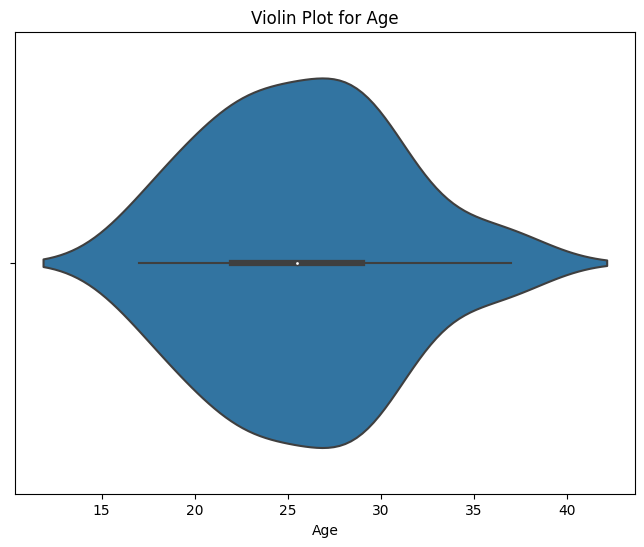

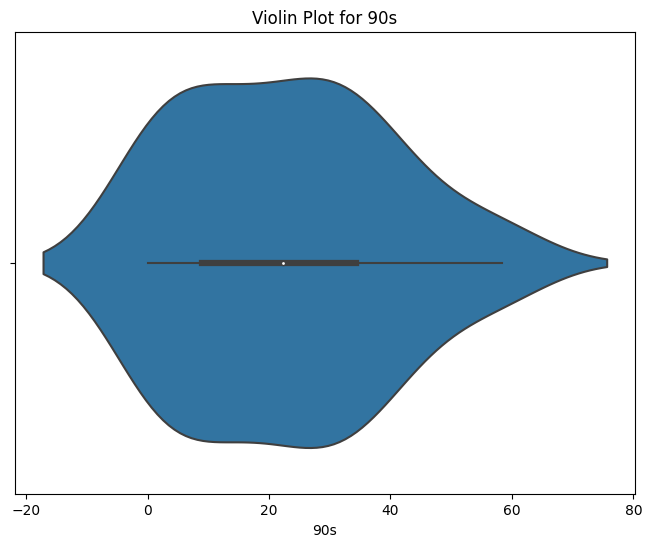

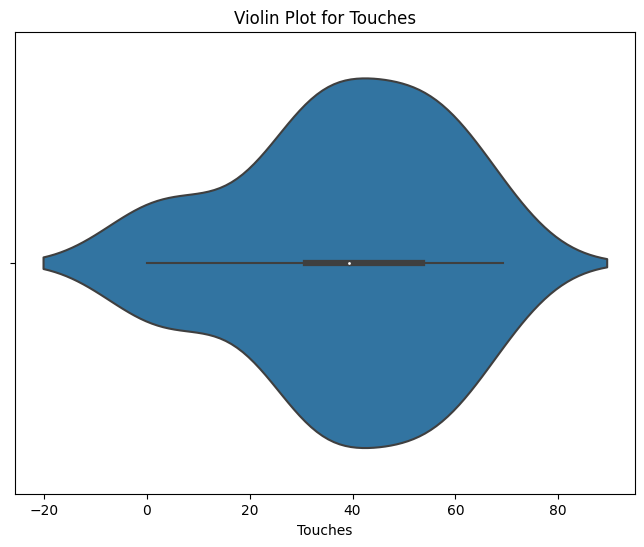

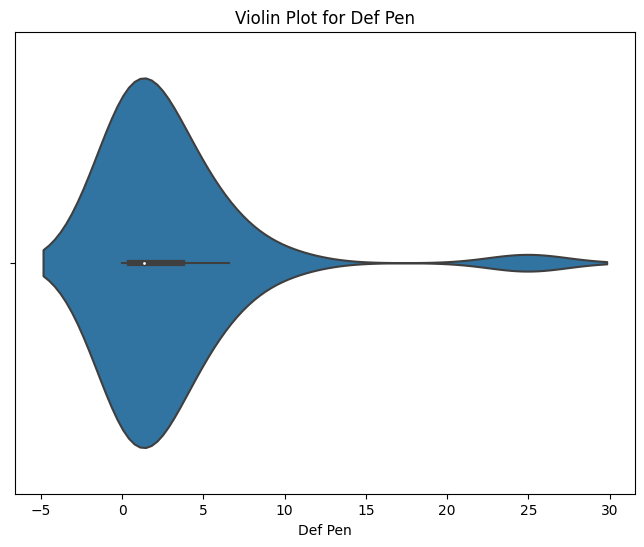

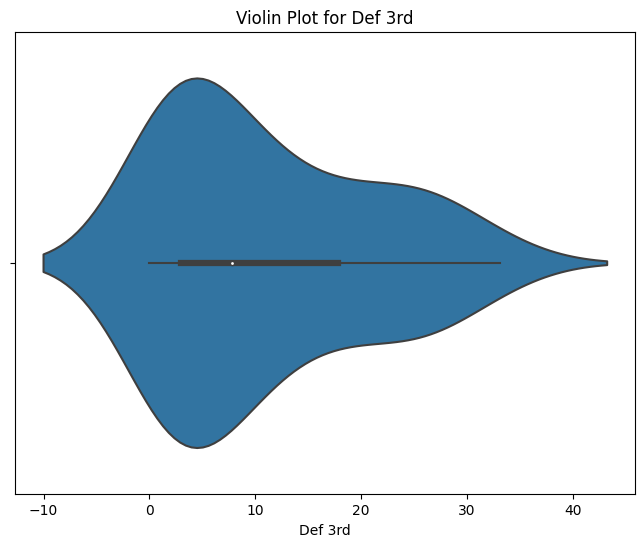

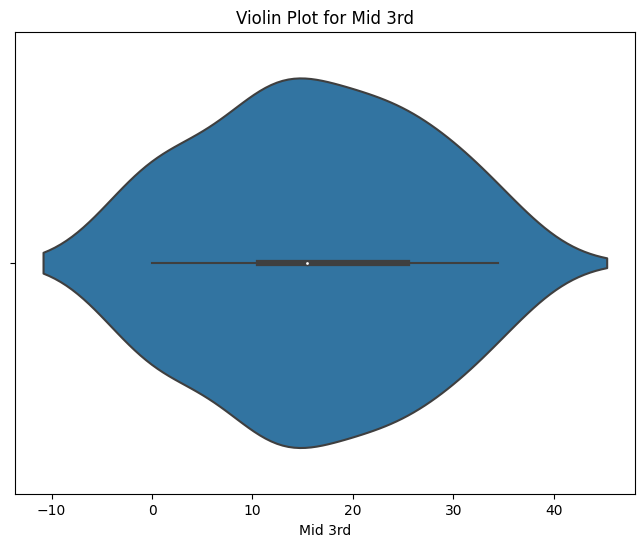

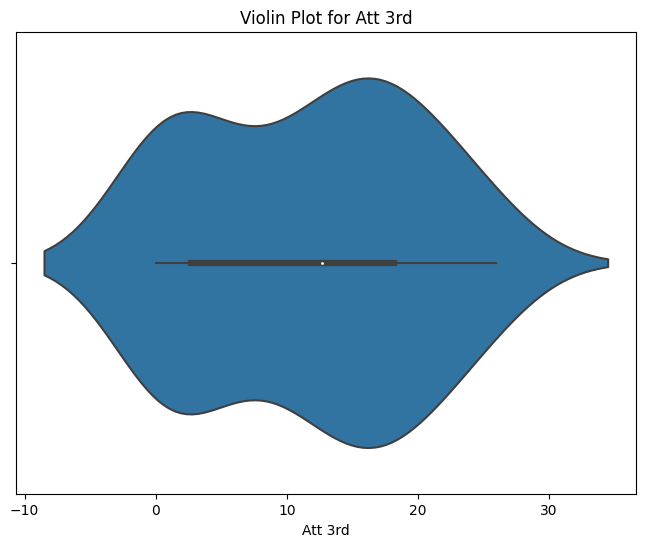

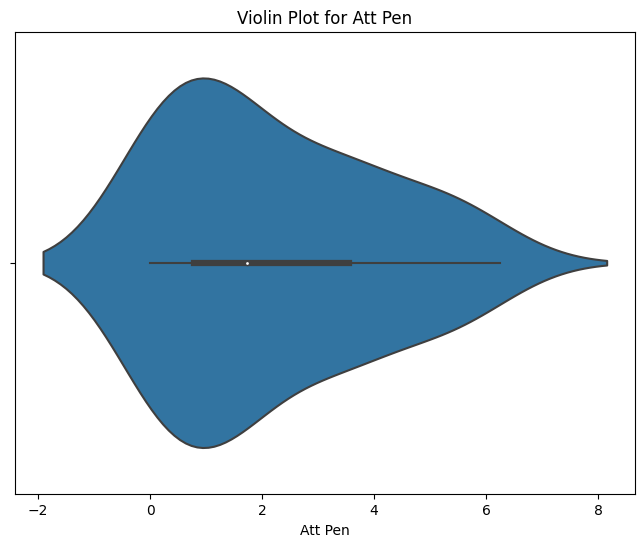

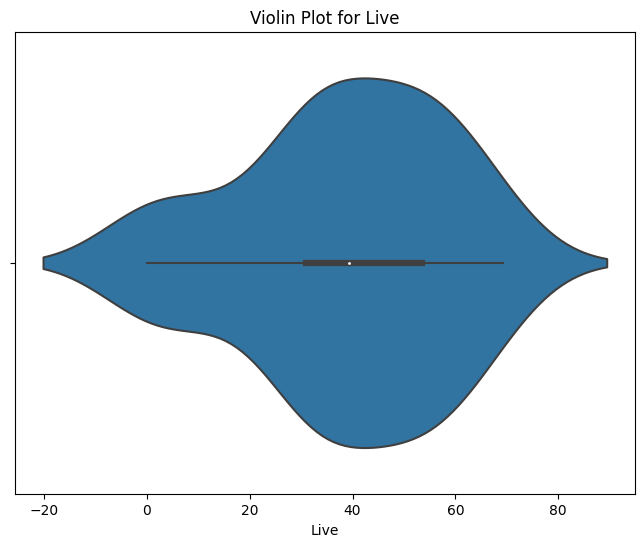

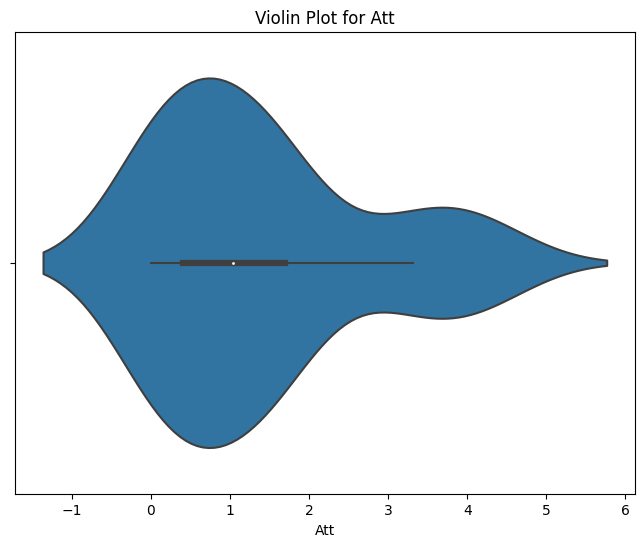

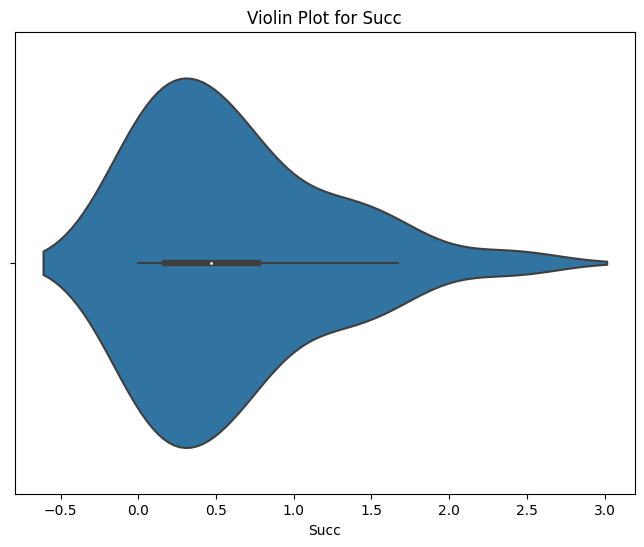

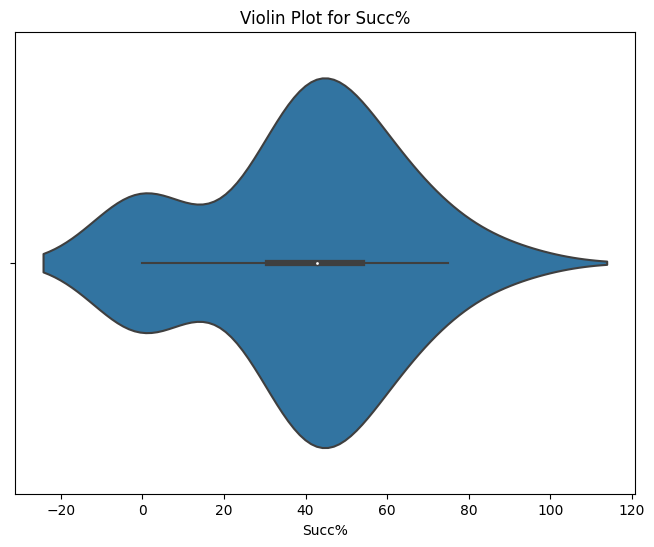

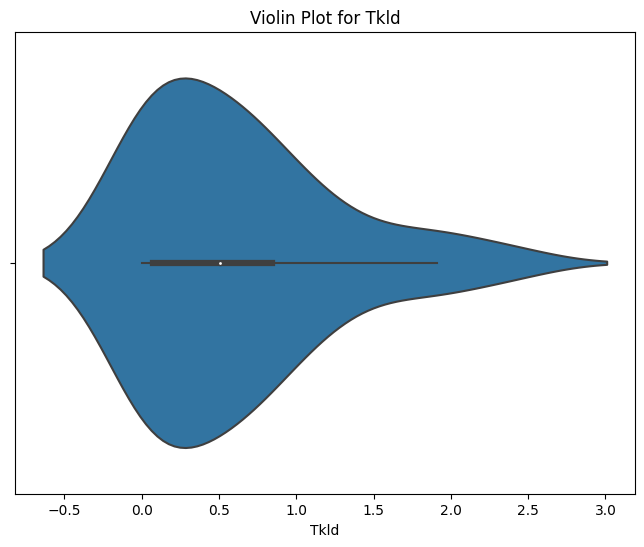

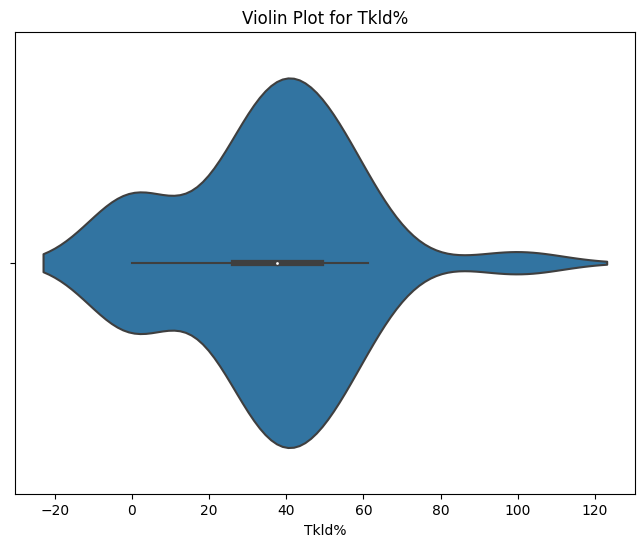

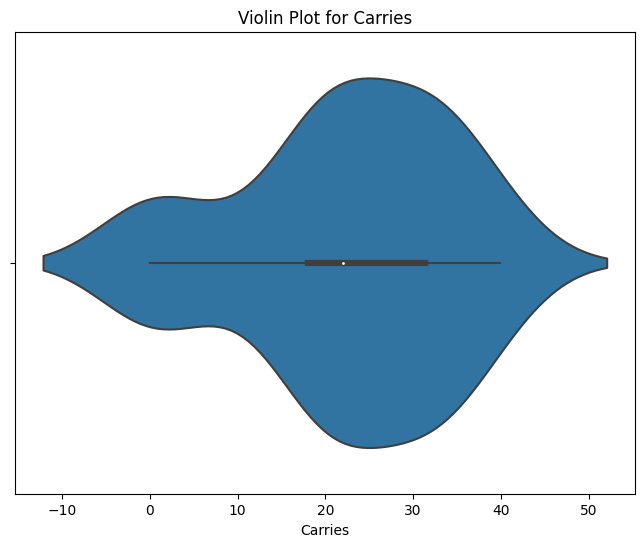

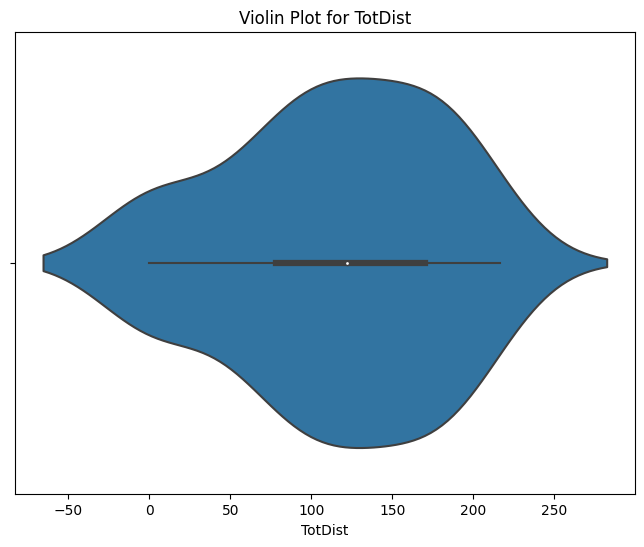

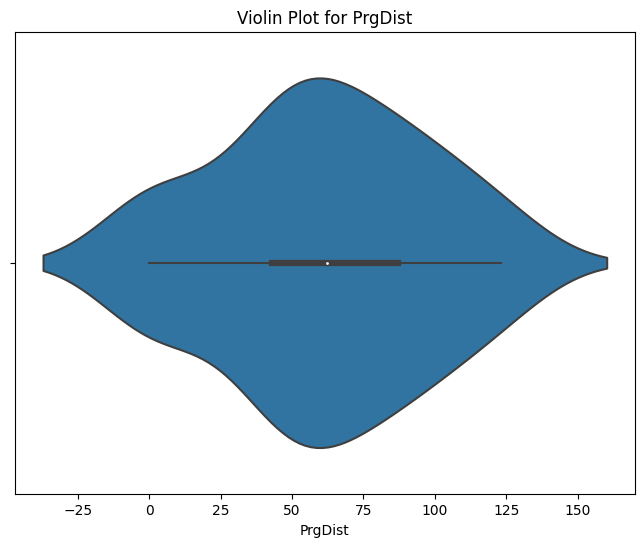

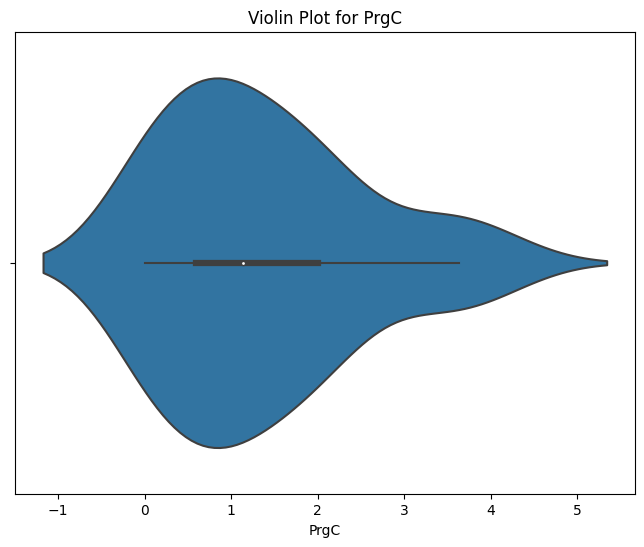

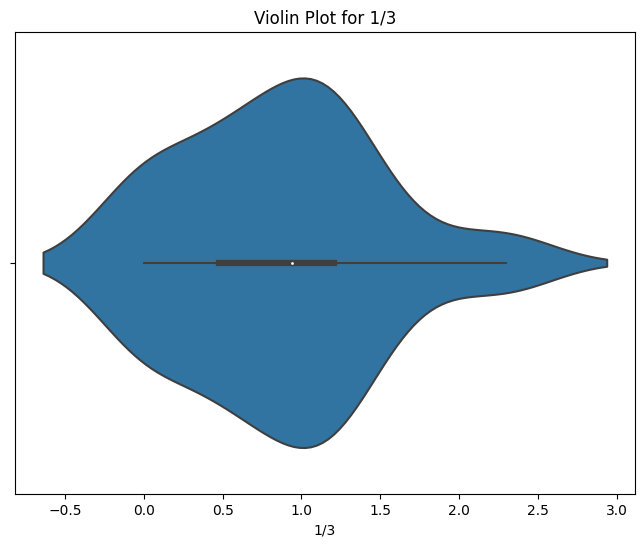

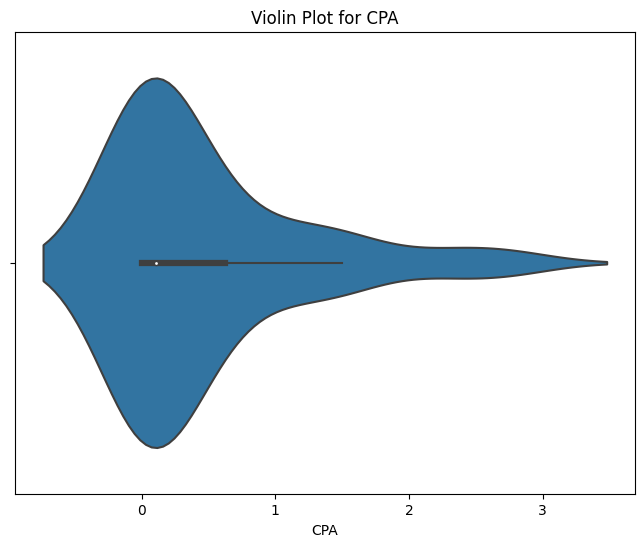

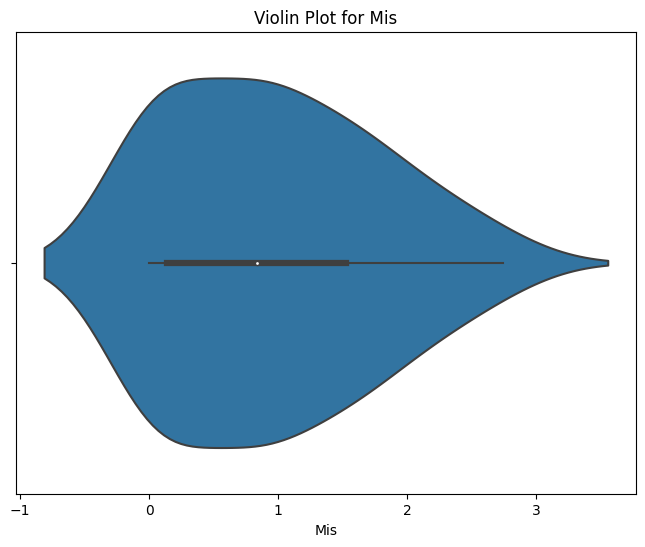

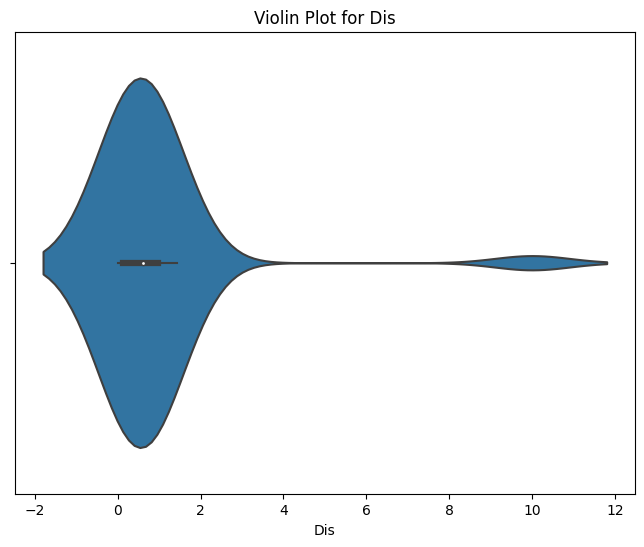

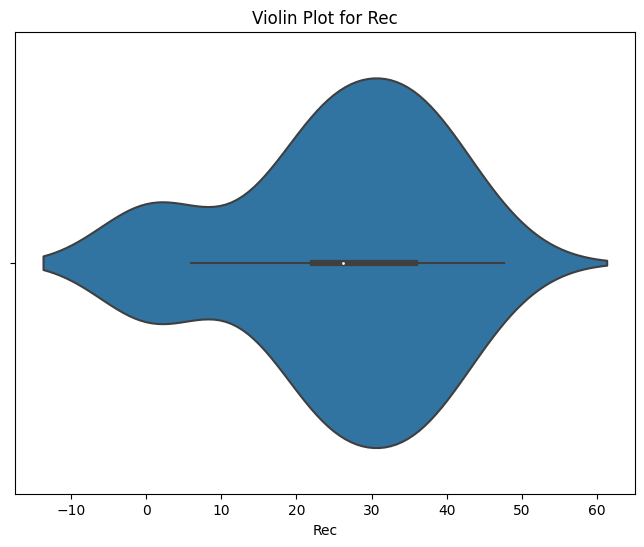

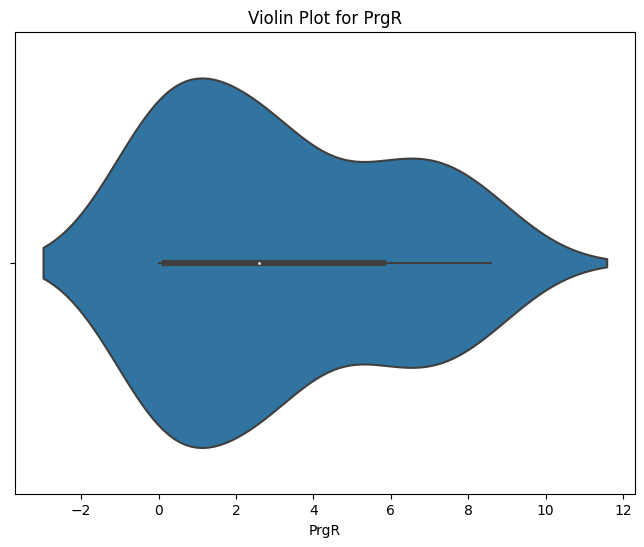

In [29]:
columns_for_plot = ['Age', '90s', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 
                    'Live', 'Att', 'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 
                    'PrgC', '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR']

# Create a violin plot for each selected column
for column in df[columns_for_plot]:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=df[column])
    plt.title(f'Violin Plot for {column}')
    plt.show()


#### Setting a new df2 for final clustering

In [30]:
df2 = df

#### Quantile capping to handle outliers

In [31]:
Q1 = 0.01
Q3 = 0.99
for column in df.columns:
    if df[column].dtype != 'object':  # Exclude object type columns from outlier capping
        q1_val = df[column].quantile(Q1)
        q3_val = df[column].quantile(Q3)
        df[column] = df[column].clip(lower=q1_val, upper=q3_val)

df.head()

Player   Nation    Pos   Age    90s    Touches    Def Pen  \
1     David de Gea   es ESP     GK  31.0  58.01  28.987993  20.565992   
2  Bruno Fernandes   pt POR  MF,FW  27.0  57.30  53.560209   1.483421   
3  Marcus Rashford  eng ENG     FW  24.0  47.60  31.764706   0.483193   
4         Casemiro   br BRA     MF  30.0  43.30  61.362587   3.533487   
5        Luke Shaw  eng ENG     DF  27.0  40.50  68.561293   4.913580   

     Def 3rd    Mid 3rd    Att 3rd  ...    Carries     TotDist    PrgDist  \
1  28.885077   0.102916   0.000000  ...  17.375643   76.740995  46.655232   
2   8.464223  21.431065  24.223386  ...  31.134380  135.863874  72.635253   
3   2.457983  10.672269  19.201681  ...  20.483193  125.546218  61.428571   
4  18.013857  33.302540  10.461894  ...  30.808314  102.263279  51.431871   
5  23.111111  31.950617  14.864198  ...  38.000000  185.777778  99.358025   

       PrgC       1/3       CPA       Mis       Dis        Rec      PrgR  
1  0.000000  0.000000  0.000000  0.017153  0.000000  17.444254  0.000000  
2  1.989529  1.361257  0.645724  1.029668  0.872600  37.591623  5.270506  
3  2.310924  1.218487  1.575630  1.995798  1.071429  24.096639  6.407563  
4  0.623557  0.508083  0.023095  0.646651  0.531178  38.314088  1.224018  
5  1.753086  1.407407  0.123457  0.740741  0.246914  42.246914  2.543210  

[5 rows x 27 columns]

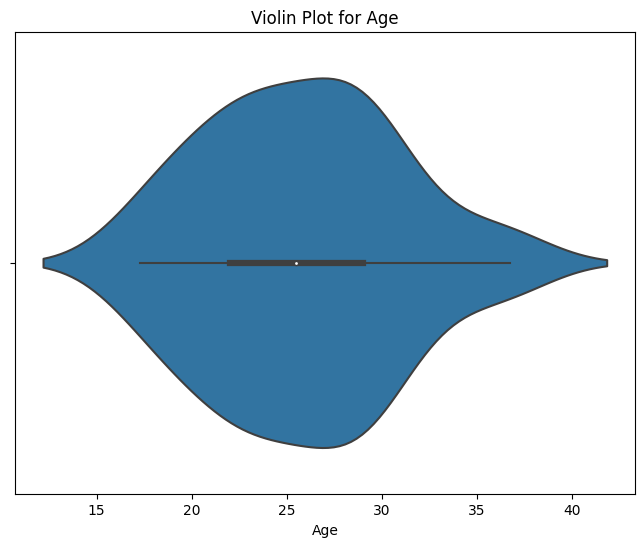

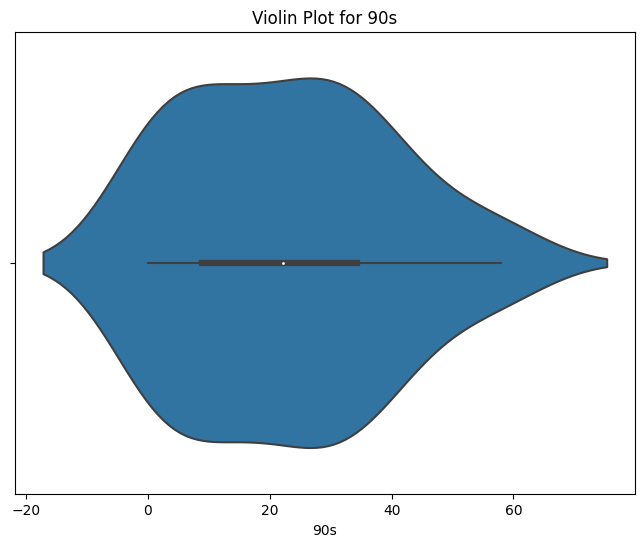

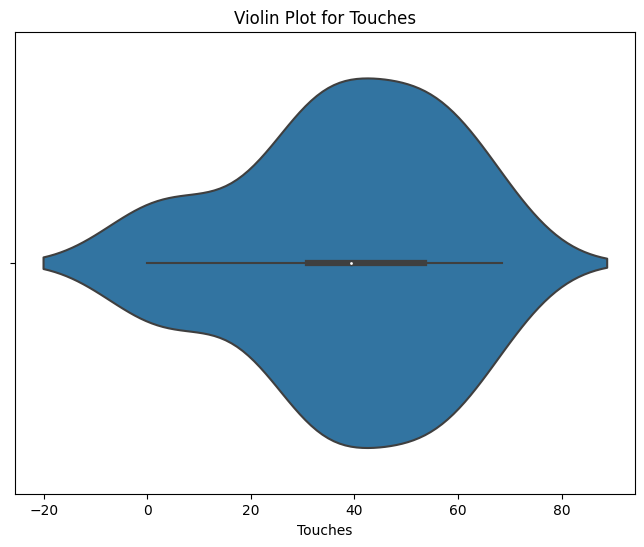

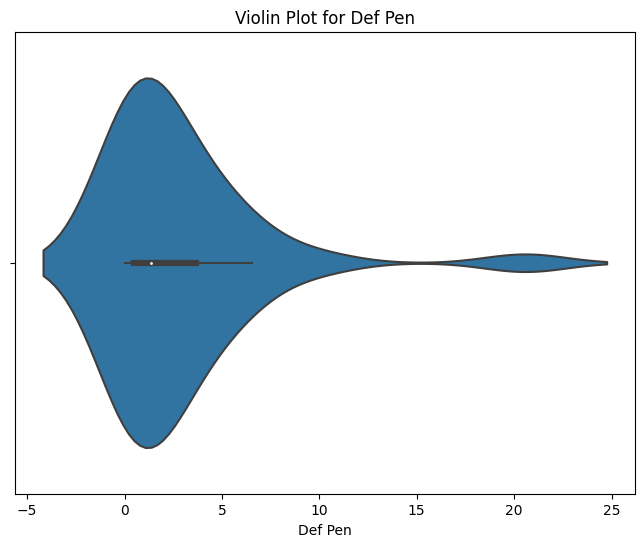

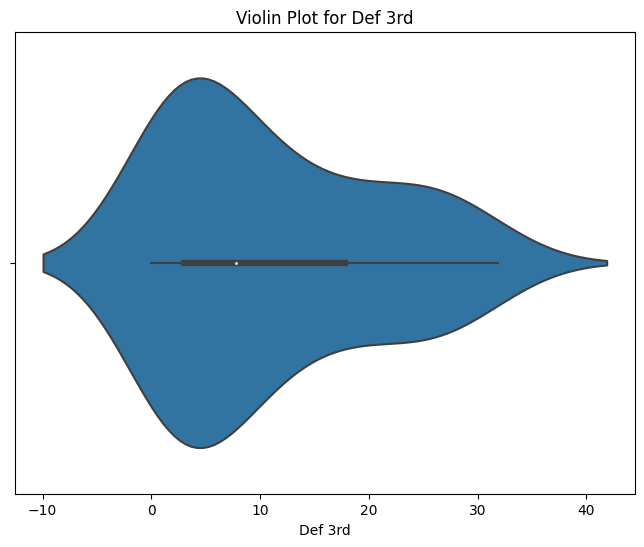

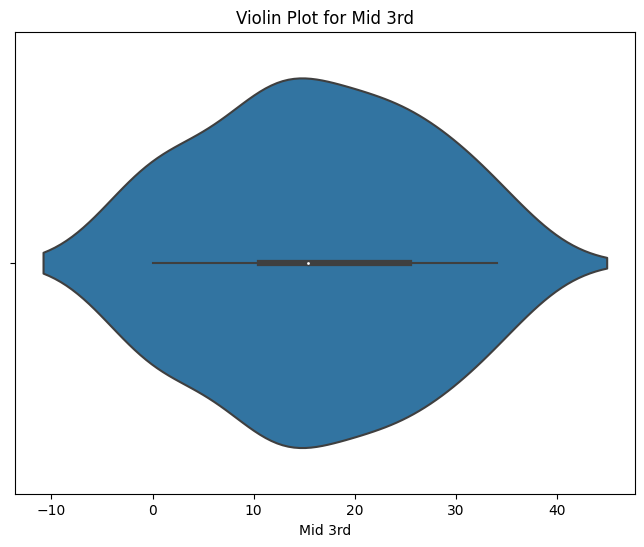

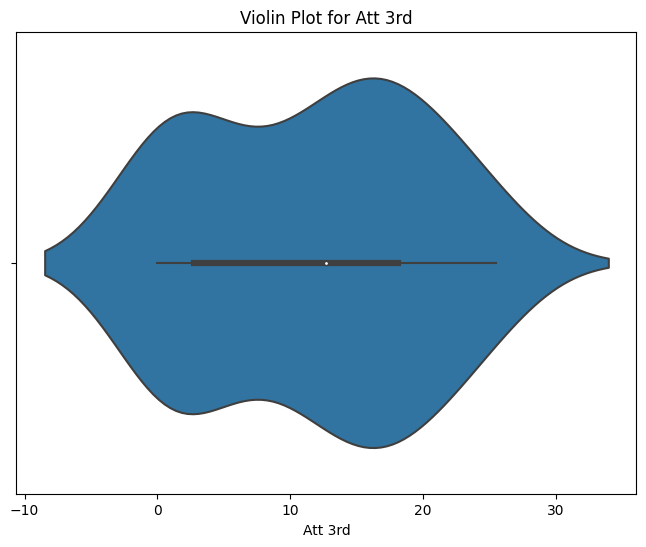

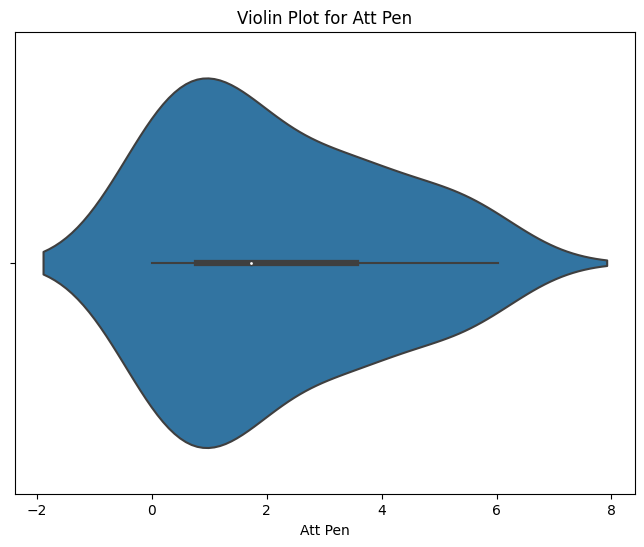

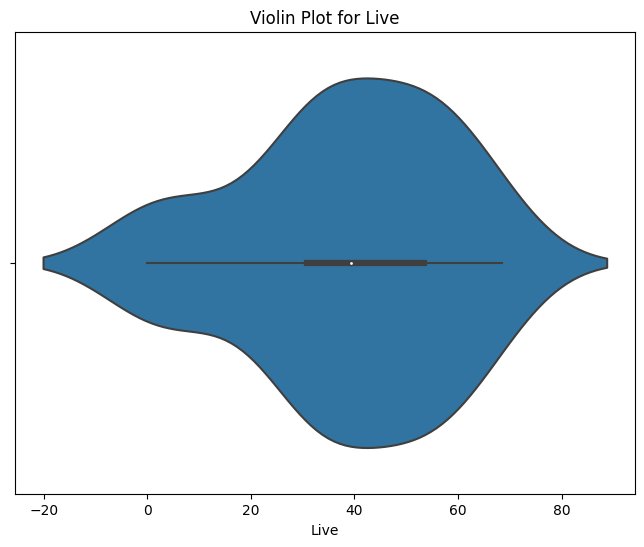

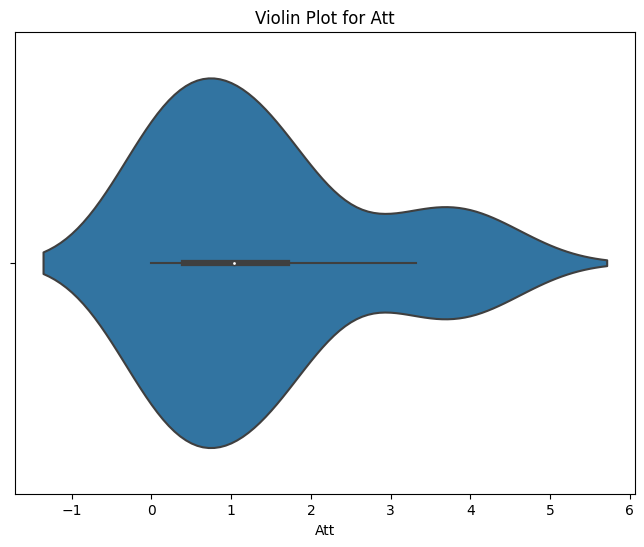

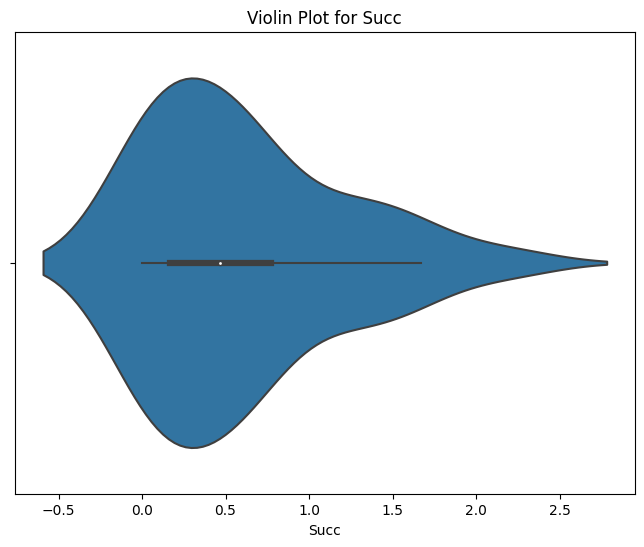

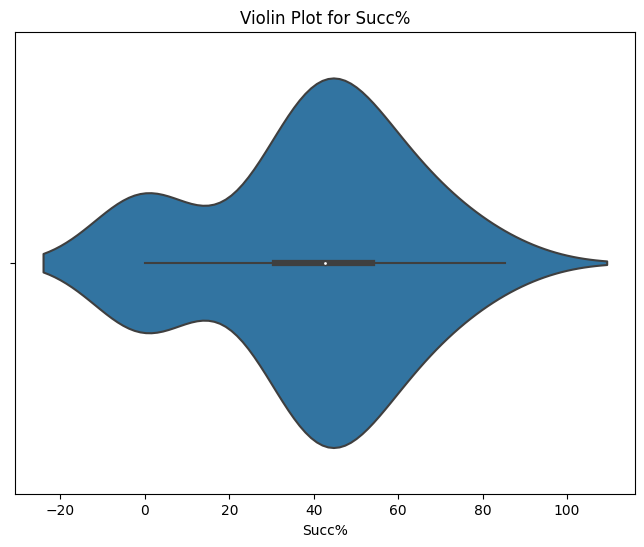

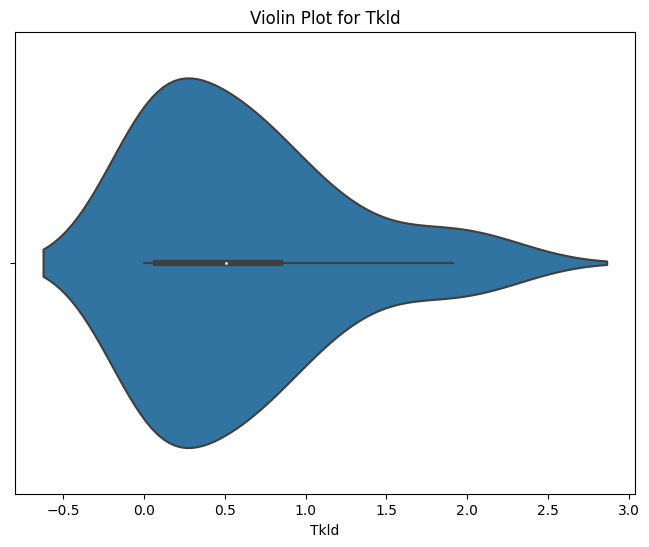

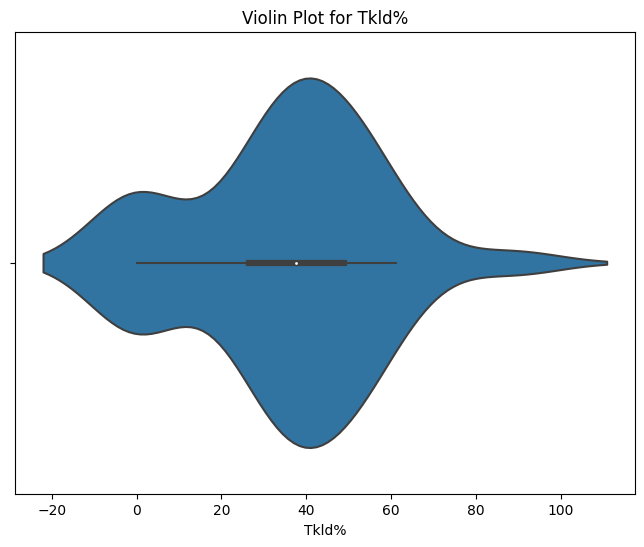

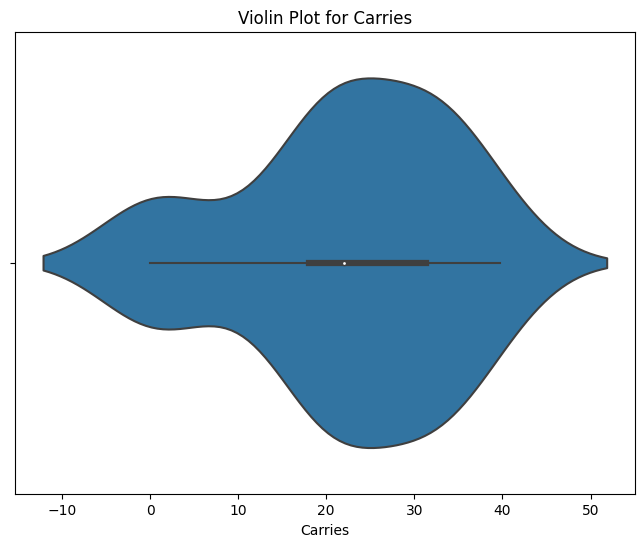

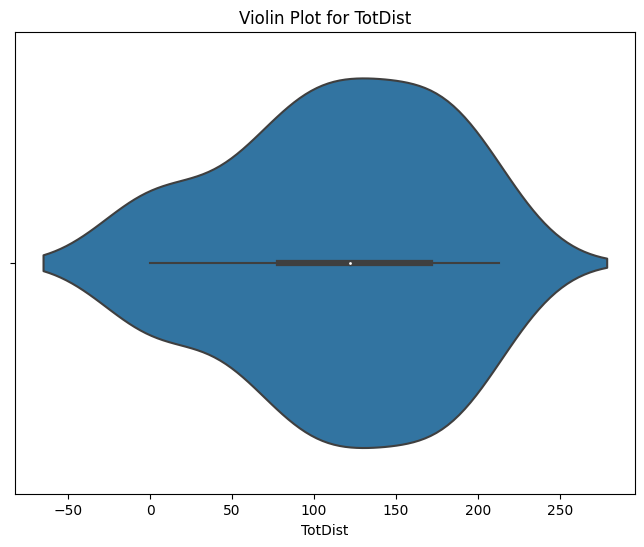

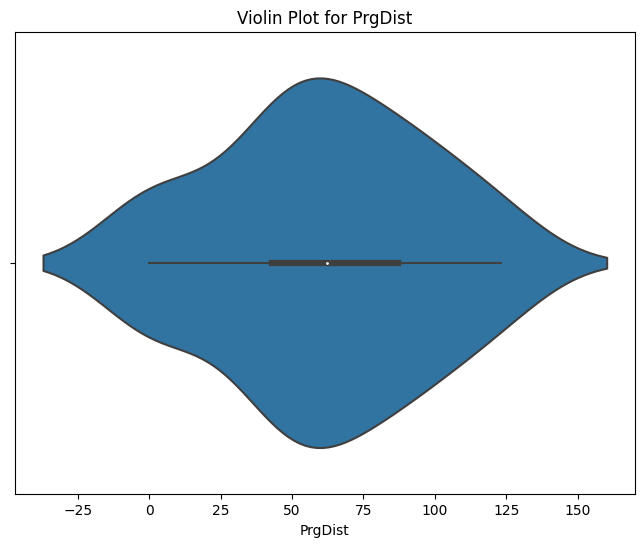

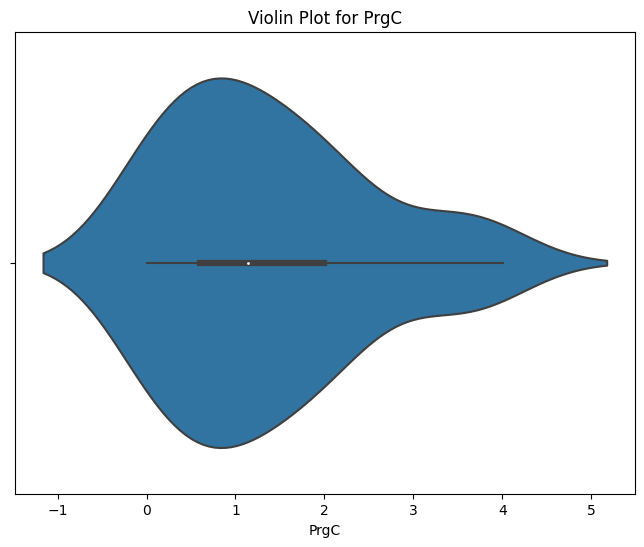

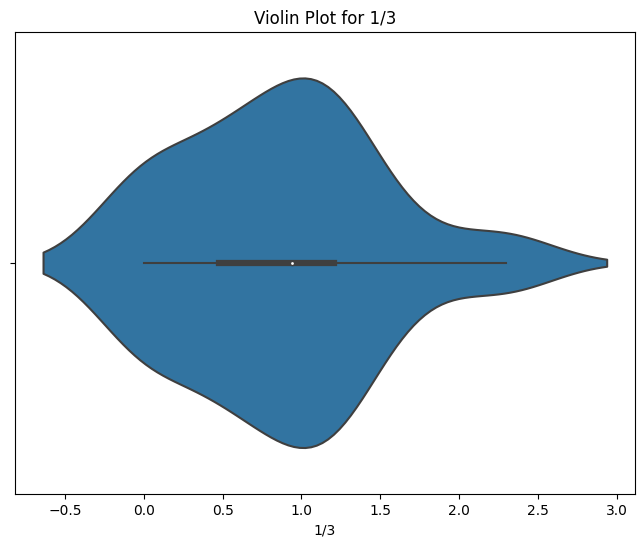

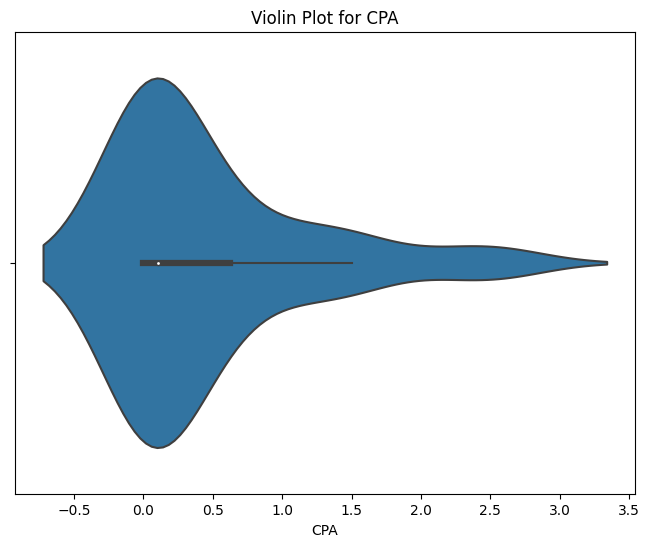

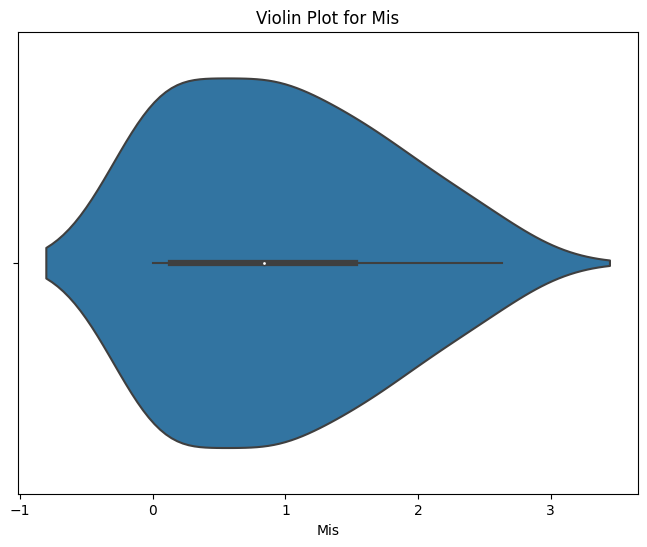

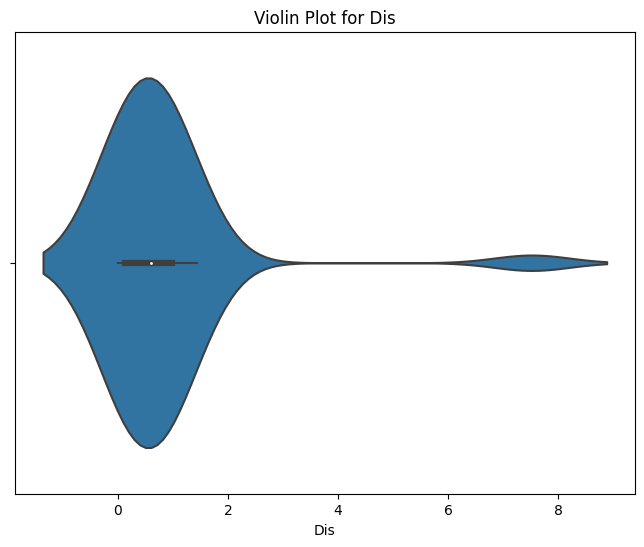

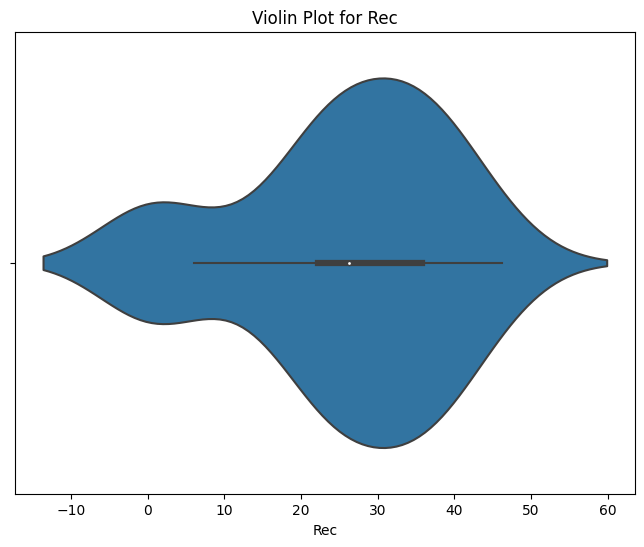

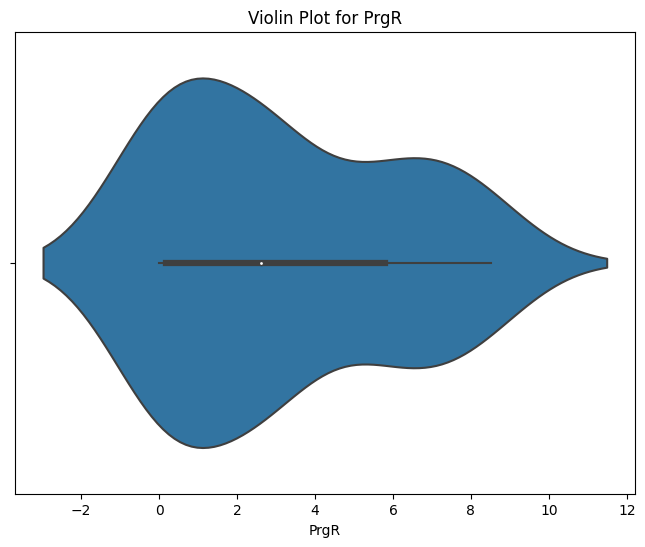

In [32]:
for column in df[columns_for_plot]:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=df[column])
    plt.title(f'Violin Plot for {column}')
    plt.show()

### Standard Scaling the numeric data

In [33]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columns_for_plot])
df_scaled = pd.DataFrame(scaler.fit_transform(df[columns_for_plot]), columns=columns_for_plot)
df_scaled.head()

Age       90s   Touches   Def Pen   Def 3rd   Mid 3rd   Att 3rd  \
0  1.048870  2.097994 -0.489137  4.370958  1.842421 -1.526643 -1.408501   
1  0.242047  2.055664  0.767800 -0.328211 -0.272067  0.502778  1.530780   
2 -0.363070  1.477354 -0.347101 -0.574521 -0.893986 -0.520945  0.921443   
3  0.847164  1.220990  1.166913  0.176627  0.716755  1.632376 -0.139048   
4  0.242047  1.054055  1.535146  0.516481  1.244553  1.503737  0.395130   

    Att Pen      Live       Att  ...   Carries   TotDist   PrgDist      PrgC  \
0 -1.182224 -0.488831 -1.058882  ... -0.426657 -0.603037 -0.399713 -1.217759   
1  0.656769  0.766335  0.131087  ...  0.740269  0.327032  0.321039  0.544875   
2  1.533608 -0.346793  1.758294  ... -0.163095  0.164724  0.010137  0.829617   
3 -0.592644  1.167239 -0.586467  ...  0.712615 -0.201543 -0.267197 -0.665316   
4 -0.753056  1.535477 -0.179676  ...  1.322566  1.112233  1.062398  0.335397   

        1/3       CPA       Mis       Dis       Rec      PrgR  
0 -1.400439 -0.666848 -1.195722 -0.599772 -0.626648 -1.103282  
1  0.793136  0.252031  0.096707  0.061152  0.893870  0.719359  
2  0.563073  1.575307  1.329926  0.211749 -0.124594  1.112575  
3 -0.581696 -0.633983 -0.392197 -0.197448  0.948394 -0.679993  
4  0.867505 -0.491166 -0.272096 -0.412755  1.245204 -0.223792  

[5 rows x 24 columns]

In [34]:
df = df.reset_index().drop('index',axis=1)
df.head()

Player   Nation    Pos   Age    90s    Touches    Def Pen  \
0     David de Gea   es ESP     GK  31.0  58.01  28.987993  20.565992   
1  Bruno Fernandes   pt POR  MF,FW  27.0  57.30  53.560209   1.483421   
2  Marcus Rashford  eng ENG     FW  24.0  47.60  31.764706   0.483193   
3         Casemiro   br BRA     MF  30.0  43.30  61.362587   3.533487   
4        Luke Shaw  eng ENG     DF  27.0  40.50  68.561293   4.913580   

     Def 3rd    Mid 3rd    Att 3rd  ...    Carries     TotDist    PrgDist  \
0  28.885077   0.102916   0.000000  ...  17.375643   76.740995  46.655232   
1   8.464223  21.431065  24.223386  ...  31.134380  135.863874  72.635253   
2   2.457983  10.672269  19.201681  ...  20.483193  125.546218  61.428571   
3  18.013857  33.302540  10.461894  ...  30.808314  102.263279  51.431871   
4  23.111111  31.950617  14.864198  ...  38.000000  185.777778  99.358025   

       PrgC       1/3       CPA       Mis       Dis        Rec      PrgR  
0  0.000000  0.000000  0.000000  0.017153  0.000000  17.444254  0.000000  
1  1.989529  1.361257  0.645724  1.029668  0.872600  37.591623  5.270506  
2  2.310924  1.218487  1.575630  1.995798  1.071429  24.096639  6.407563  
3  0.623557  0.508083  0.023095  0.646651  0.531178  38.314088  1.224018  
4  1.753086  1.407407  0.123457  0.740741  0.246914  42.246914  2.543210  

[5 rows x 27 columns]

#### Concating the original columns with the scaled column

In [35]:
df = pd.concat([df[df.columns[:3]], df_scaled], axis=1)
df.head()

Player   Nation    Pos       Age       90s   Touches   Def Pen  \
0     David de Gea   es ESP     GK  1.048870  2.097994 -0.489137  4.370958   
1  Bruno Fernandes   pt POR  MF,FW  0.242047  2.055664  0.767800 -0.328211   
2  Marcus Rashford  eng ENG     FW -0.363070  1.477354 -0.347101 -0.574521   
3         Casemiro   br BRA     MF  0.847164  1.220990  1.166913  0.176627   
4        Luke Shaw  eng ENG     DF  0.242047  1.054055  1.535146  0.516481   

    Def 3rd   Mid 3rd   Att 3rd  ...   Carries   TotDist   PrgDist      PrgC  \
0  1.842421 -1.526643 -1.408501  ... -0.426657 -0.603037 -0.399713 -1.217759   
1 -0.272067  0.502778  1.530780  ...  0.740269  0.327032  0.321039  0.544875   
2 -0.893986 -0.520945  0.921443  ... -0.163095  0.164724  0.010137  0.829617   
3  0.716755  1.632376 -0.139048  ...  0.712615 -0.201543 -0.267197 -0.665316   
4  1.244553  1.503737  0.395130  ...  1.322566  1.112233  1.062398  0.335397   

        1/3       CPA       Mis       Dis       Rec      PrgR  
0 -1.400439 -0.666848 -1.195722 -0.599772 -0.626648 -1.103282  
1  0.793136  0.252031  0.096707  0.061152  0.893870  0.719359  
2  0.563073  1.575307  1.329926  0.211749 -0.124594  1.112575  
3 -0.581696 -0.633983 -0.392197 -0.197448  0.948394 -0.679993  
4  0.867505 -0.491166 -0.272096 -0.412755  1.245204 -0.223792  

[5 rows x 27 columns]

### Encoding

#### Players name according to their numbers

In [36]:
# # Sample data
# data = {'Player': ['David de Gea', 'Bruno Fernandes', 'Marcus Rashford', 'Casemiro',
#                     'Luke Shaw', 'Lisandro Martínez', 'Diogo Dalot', 'Antony',
#                     'Christian Eriksen', 'Tyrell Malacia', 'Raphaël Varane',
#                     'Aaron Wan-Bissaka', 'Victor Lindelöf', 'Jadon Sancho', 'Fred',
#                     'Scott McTominay', 'Wout Weghorst', 'Harry Maguire',
#                     'Anthony Martial', 'Alejandro Garnacho', 'Cristiano Ronaldo',
#                     'Marcel Sabitzer', 'Anthony Elanga', 'Donny van de Beek',
#                     'Facundo Pellistri', 'Martin Dúbravka', 'Tom Heaton',
#                     'Kobbie Mainoo', 'Charlie McNeill', 'Brandon Williams'],
#         'Jersey Number': [1, 18, 10, 14, 23, 21, 20, 17, 24, 22, 19, 29, 2, 25, 17,
#                            39, 9, 5, 9, 33, 7, 18, 56, 34, 28, 26, 22, 54, 52, 53]}

# df_number = pd.DataFrame(data)

# # Create a dictionary mapping player names to jersey numbers
# player_jersey_mapping = dict(zip(df_number['Player'], df_number['Jersey Number']))

# # Iterate through each row in the DataFrame and update the 'Player' column with encoded values
# for index, row in df_number.iterrows():
#     df.loc[index, 'Player'] = player_jersey_mapping[row['Player']]

# df.head()

#### Perform One-Hot Encoding on the 'Nation' column

In [37]:
# df_encoded = pd.get_dummies(df, columns=['Nation'], prefix='Nation')
# df_encoded = df_encoded[df_encoded.columns].replace({True: 1, False: 0})
# df_encoded

#### One hot encoding to Position column 

In [38]:
df['Pos'] = df['Pos'].replace({'GK': 1, 'DF': 2, 'MF,FW': 3, 
                                               'FW,MF': 4, 'FW': 5,'MF':6})
df.head()

/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_16346/2375255116.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Player   Nation  Pos       Age       90s   Touches   Def Pen  \
0     David de Gea   es ESP    1  1.048870  2.097994 -0.489137  4.370958   
1  Bruno Fernandes   pt POR    3  0.242047  2.055664  0.767800 -0.328211   
2  Marcus Rashford  eng ENG    5 -0.363070  1.477354 -0.347101 -0.574521   
3         Casemiro   br BRA    6  0.847164  1.220990  1.166913  0.176627   
4        Luke Shaw  eng ENG    2  0.242047  1.054055  1.535146  0.516481   

    Def 3rd   Mid 3rd   Att 3rd  ...   Carries   TotDist   PrgDist      PrgC  \
0  1.842421 -1.526643 -1.408501  ... -0.426657 -0.603037 -0.399713 -1.217759   
1 -0.272067  0.502778  1.530780  ...  0.740269  0.327032  0.321039  0.544875   
2 -0.893986 -0.520945  0.921443  ... -0.163095  0.164724  0.010137  0.829617   
3  0.716755  1.632376 -0.139048  ...  0.712615 -0.201543 -0.267197 -0.665316   
4  1.244553  1.503737  0.395130  ...  1.322566  1.112233  1.062398  0.335397   

        1/3       CPA       Mis       Dis       Rec      PrgR  
0 -1.400439 -0.666848 -1.195722 -0.599772 -0.626648 -1.103282  
1  0.793136  0.252031  0.096707  0.061152  0.893870  0.719359  
2  0.563073  1.575307  1.329926  0.211749 -0.124594  1.112575  
3 -0.581696 -0.633983 -0.392197 -0.197448  0.948394 -0.679993  
4  0.867505 -0.491166 -0.272096 -0.412755  1.245204 -0.223792  

[5 rows x 27 columns]

In [39]:
df_final = df.drop(['Player','Nation'],axis=1)
df_final.head()

Pos       Age       90s   Touches   Def Pen   Def 3rd   Mid 3rd   Att 3rd  \
0    1  1.048870  2.097994 -0.489137  4.370958  1.842421 -1.526643 -1.408501   
1    3  0.242047  2.055664  0.767800 -0.328211 -0.272067  0.502778  1.530780   
2    5 -0.363070  1.477354 -0.347101 -0.574521 -0.893986 -0.520945  0.921443   
3    6  0.847164  1.220990  1.166913  0.176627  0.716755  1.632376 -0.139048   
4    2  0.242047  1.054055  1.535146  0.516481  1.244553  1.503737  0.395130   

    Att Pen      Live  ...   Carries   TotDist   PrgDist      PrgC       1/3  \
0 -1.182224 -0.488831  ... -0.426657 -0.603037 -0.399713 -1.217759 -1.400439   
1  0.656769  0.766335  ...  0.740269  0.327032  0.321039  0.544875  0.793136   
2  1.533608 -0.346793  ... -0.163095  0.164724  0.010137  0.829617  0.563073   
3 -0.592644  1.167239  ...  0.712615 -0.201543 -0.267197 -0.665316 -0.581696   
4 -0.753056  1.535477  ...  1.322566  1.112233  1.062398  0.335397  0.867505   

        CPA       Mis       Dis       Rec      PrgR  
0 -0.666848 -1.195722 -0.599772 -0.626648 -1.103282  
1  0.252031  0.096707  0.061152  0.893870  0.719359  
2  1.575307  1.329926  0.211749 -0.124594  1.112575  
3 -0.633983 -0.392197 -0.197448  0.948394 -0.679993  
4 -0.491166 -0.272096 -0.412755  1.245204 -0.223792  

[5 rows x 25 columns]

### Plotting the elbow points
Looks like the elbow point lies between 2 and 3

In [40]:
df_lat = df_final.drop('Pos',axis=1)

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anacond

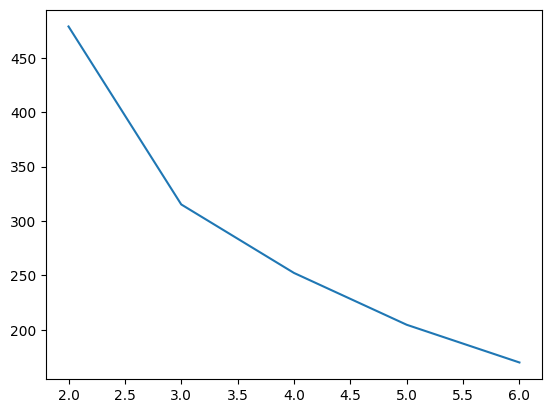

In [41]:
# Elbow curve method to find the ideal number of clusters.
clusters=list(range(2,7))
ssd = []
for num_clusters in clusters:
    model_clus = KMeans(n_clusters = num_clusters, max_iter=150,random_state= 50)
    model_clus.fit(df_lat)
    ssd.append(model_clus.inertia_)

plt.plot(clusters,ssd);

### Calculating the silhouette score
Looks like silhouette score for 4 is the best

In [42]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state= 100)
    kmeans.fit(df_final)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_final, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=2, the silhouette score is 0.3326491442696441
For n_clusters=3, the silhouette score is 0.3116632068350047
For n_clusters=4, the silhouette score is 0.34118075581692714
For n_clusters=5, the silhouette score is 0.3485014740317553
For n_clusters=6, the silhouette score is 0.3130677306537108
For n_clusters=7, the silhouette score is 0.3335807379028729
For n_clusters=8, the silhouette score is 0.3316754570127003


/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/asheshlalshrestha/anacond

### Applying KMean algorithm with 4 clusters

In [43]:
cluster = KMeans(n_clusters=4, max_iter=150, random_state= 15)
cluster.fit(df_lat)

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(max_iter=150, n_clusters=4, random_state=15)

### Applying the cluster id to df2
Now each player will have the assigned cluster

In [44]:
df2['Cluster_Id'] = cluster.labels_
df2.head()

Player   Nation    Pos   Age    90s    Touches    Def Pen  \
1     David de Gea   es ESP     GK  31.0  58.01  28.987993  20.565992   
2  Bruno Fernandes   pt POR  MF,FW  27.0  57.30  53.560209   1.483421   
3  Marcus Rashford  eng ENG     FW  24.0  47.60  31.764706   0.483193   
4         Casemiro   br BRA     MF  30.0  43.30  61.362587   3.533487   
5        Luke Shaw  eng ENG     DF  27.0  40.50  68.561293   4.913580   

     Def 3rd    Mid 3rd    Att 3rd  ...     TotDist    PrgDist      PrgC  \
1  28.885077   0.102916   0.000000  ...   76.740995  46.655232  0.000000   
2   8.464223  21.431065  24.223386  ...  135.863874  72.635253  1.989529   
3   2.457983  10.672269  19.201681  ...  125.546218  61.428571  2.310924   
4  18.013857  33.302540  10.461894  ...  102.263279  51.431871  0.623557   
5  23.111111  31.950617  14.864198  ...  185.777778  99.358025  1.753086   

        1/3       CPA       Mis       Dis        Rec      PrgR  Cluster_Id  
1  0.000000  0.000000  0.017153  0.000000  17.444254  0.000000           0  
2  1.361257  0.645724  1.029668  0.872600  37.591623  5.270506           3  
3  1.218487  1.575630  1.995798  1.071429  24.096639  6.407563           1  
4  0.508083  0.023095  0.646651  0.531178  38.314088  1.224018           0  
5  1.407407  0.123457  0.740741  0.246914  42.246914  2.543210           0  

[5 rows x 28 columns]

In [45]:
df2.Cluster_Id.value_counts(ascending=True)

Cluster_Id
2     5
1     6
3     9
0    10
Name: count, dtype: int64

### Now we can see the clusters of the players
This can be done for any of the features

In [46]:
fig = px.scatter(df2, x='Touches', y='Pos', color='Cluster_Id', title='Scatter Plot with Plotly Express')
fig.show()

In [47]:
df2[df2['Cluster_Id']==0]

Player   Nation Pos   Age    90s    Touches    Def Pen  \
1        David de Gea   es ESP  GK  31.0  58.01  28.987993  20.565992   
4            Casemiro   br BRA  MF  30.0  43.30  61.362587   3.533487   
5           Luke Shaw  eng ENG  DF  27.0  40.50  68.561293   4.913580   
6   Lisandro Martínez   ar ARG  DF  24.0  37.90  66.912929   9.815303   
7         Diogo Dalot   pt POR  DF  23.0  36.00  60.805556   3.916667   
9   Christian Eriksen   dk DEN  MF  30.0  34.00  63.323529   1.500000   
10     Tyrell Malacia   nl NED  DF  22.0  29.90  51.973244   2.508361   
11     Raphaël Varane   fr FRA  DF  29.0  29.60  53.310811   6.114865   
13    Victor Lindelöf   se SWE  DF  28.0  27.90  54.551971   6.559140   
18      Harry Maguire  eng ENG  DF  29.0  17.90  53.407821   5.642458   

      Def 3rd    Mid 3rd    Att 3rd  ...     TotDist     PrgDist      PrgC  \
1   28.885077   0.102916   0.000000  ...   76.740995   46.655232  0.000000   
4   18.013857  33.302540  10.461894  ...  102.263279   51.431871  0.623557   
5   23.111111  31.950617  14.864198  ...  185.777778   99.358025  1.753086   
6   31.924693  31.899736   2.401055  ...  204.538259  121.187335  0.791557   
7   20.611111  25.944444  14.666667  ...  160.027778   82.750000  1.805556   
9   10.058824  34.090090  19.029412  ...  147.235294   76.647059  1.176471   
10  17.090301  21.906355  13.377926  ...  132.508361   70.501672  1.337793   
11  25.236486  26.047297   2.297297  ...  213.213392  122.961054  0.743243   
13  25.627240  26.415771   2.580645  ...  167.311828   88.458781  0.394265   
18  27.039106  23.687151   3.128492  ...  194.301676  122.849162  0.670391   

         1/3       CPA       Mis       Dis        Rec      PrgR  Cluster_Id  
1   0.000000  0.000000  0.017153  0.000000  17.444254  0.000000           0  
4   0.508083  0.023095  0.646651  0.531178  38.314088  1.224018           0  
5   1.407407  0.123457  0.740741  0.246914  42.246914  2.543210           0  
6   0.659631  0.000000  0.448549  0.263852  43.007916  0.052770           0  
7   1.166667  0.388889  0.750000  0.194444  36.805556  3.166667           0  
9   1.323529  0.088235  1.000000  0.735294  46.239060  2.470588           0  
10  1.137124  0.234114  0.769231  0.468227  30.735786  2.140468           0  
11  0.608108  0.000000  0.135135  0.067568  34.527027  0.135135           0  
13  0.465950  0.000000  0.143369  0.107527  38.243728  0.107527           0  
18  0.558659  0.055866  0.111732  0.000000  36.201117  0.279330           0  

[10 rows x 28 columns]

In [48]:
df2[df2['Cluster_Id']==1]

Player   Nation    Pos   Age   90s    Touches   Def Pen  \
3      Marcus Rashford  eng ENG     FW  24.0  47.6  31.764706  0.483193   
8               Antony   br BRA     FW  22.0  34.4  41.831395  0.436047   
14        Jadon Sancho  eng ENG  FW,MF  22.0  26.9  46.877323  0.631970   
20  Alejandro Garnacho   ar ARG  FW,MF  18.0  13.5  31.185185  0.592593   
23      Anthony Elanga   se SWE     FW  20.0   8.0  34.125000  0.750000   
25   Facundo Pellistri   uy URU  FW,MF  20.0   2.5  32.800000  0.800000   

     Def 3rd    Mid 3rd    Att 3rd  ...     TotDist     PrgDist      PrgC  \
3   2.457983  10.672269  19.201681  ...  125.546218   61.428571  2.310924   
8   5.029070  13.808140  23.953488  ...  185.930233   96.656977  3.575581   
14  5.315985  16.245353  25.447830  ...  182.490706  101.784387  4.008726   
20  3.259259   8.074074  20.222222  ...  178.518519   97.185185  3.629630   
23  4.125000  11.875000  18.375000  ...  130.125000   62.750000  2.500000   
25  7.200000  11.600000  15.200000  ...  171.600000   76.400000  3.200000   

         1/3       CPA       Mis       Dis        Rec      PrgR  Cluster_Id  
3   1.218487  1.575630  1.995798  1.071429  24.096639  6.407563           1  
8   2.296449  1.162791  1.540698  0.610465  31.715116  7.238372           1  
14  1.784387  2.304833  2.379182  1.003717  34.312268  8.289963           1  
20  2.296296  2.614327  2.635889  1.185185  24.000000  8.504830           1  
23  0.875000  1.500000  1.875000  1.125000  24.375000  5.875000           1  
25  1.200000  1.200000  1.600000  0.800000  22.000000  5.600000           1  

[6 rows x 28 columns]

In [49]:
df2[df2['Cluster_Id']==2]

Player   Nation Pos    Age  90s  Touches  Def Pen  Def 3rd  \
26   Martin Dúbravka   sk SVK  GK  33.00  2.0      0.0      0.0      0.0   
27        Tom Heaton  eng ENG  GK  36.00  2.0      0.0      0.0      0.0   
28     Kobbie Mainoo  eng ENG  MF  17.29  1.0     11.0      0.0      2.0   
29   Charlie McNeill  eng ENG  DF  18.00  0.1     10.0      0.0     10.0   
30  Brandon Williams  eng ENG  DF  21.00  0.1      0.0      0.0      0.0   

    Mid 3rd  Att 3rd  ...  TotDist  PrgDist  PrgC  1/3  CPA  Mis       Dis  \
26      0.0      0.0  ...      0.0      0.0   0.0  0.0  0.0  0.0  0.000000   
27      0.0      0.0  ...      0.0      0.0   0.0  0.0  0.0  0.0  0.000000   
28      4.0      5.0  ...     64.0     48.0   2.0  0.0  0.0  0.0  0.000000   
29      0.0      0.0  ...      0.0      0.0   0.0  0.0  0.0  0.0  7.516875   
30      0.0      0.0  ...      0.0      0.0   0.0  0.0  0.0  0.0  0.000000   

    Rec  PrgR  Cluster_Id  
26  0.0   0.0           2  
27  0.0   0.0           2  
28  6.0   1.0           2  
29  0.0   0.0           2  
30  0.0   0.0           2  

[5 rows x 28 columns]

In [50]:
df2[df2['Cluster_Id']==3]

Player   Nation    Pos    Age   90s    Touches   Def Pen  \
2     Bruno Fernandes   pt POR  MF,FW  27.00  57.3  53.560209  1.483421   
12  Aaron Wan-Bissaka  eng ENG     DF  24.00  28.5  45.894737  3.298246   
15               Fred   br BRA     MF  29.00  25.5  53.490196  1.882353   
16    Scott McTominay  sct SCO     MF  25.00  19.0  38.421053  3.736842   
17      Wout Weghorst   nl NED  FW,MF  29.00  18.6  21.827957  1.236559   
19    Anthony Martial   fr FRA     FW  26.00  16.0  31.000000  0.687500   
21  Cristiano Ronaldo   pt POR     FW  36.71  11.7  39.658120  0.940171   
22    Marcel Sabitzer   at AUT     MF  28.00  11.6  38.965517  2.155172   
24  Donny van de Beek   nl NED     MF  25.00   3.3  30.909091  0.303030   

      Def 3rd    Mid 3rd    Att 3rd  ...     TotDist    PrgDist      PrgC  \
2    8.464223  21.431065  24.223386  ...  135.863874  72.635253  1.989529   
12  16.105263  18.175439  11.929825  ...  118.877193  63.017544  2.000000   
15  12.039216  25.882353  16.156863  ...  113.843137  52.549020  0.588235   
16  11.789474  18.315789   8.684211  ...   96.368421  48.157895  1.105263   
17   3.172043  10.698925   8.118280  ...   36.236559  12.795699  0.322581   
19   2.187500  11.812500  17.437500  ...   95.500000  41.875000  1.312500   
21   2.991453  14.529915  22.307692  ...   83.418803  46.581197  1.452991   
22   6.896552  20.431034  11.896552  ...   86.982759  38.793103  1.034483   
24   2.121212  11.515152  17.272727  ...   63.030303  28.484848  0.909091   

         1/3       CPA       Mis       Dis        Rec      PrgR  Cluster_Id  
2   1.361257  0.645724  1.029668  0.872600  37.591623  5.270506           3  
12  1.087719  0.315789  0.701754  0.421053  26.245614  2.666667           3  
15  0.941176  0.196078  1.450980  1.019608  33.882353  3.215686           3  
16  1.052632  0.157895  1.473684  1.052632  22.894737  1.578947           3  
17  0.430108  0.053763  1.182796  0.913978  14.677419  3.064516           3  
19  0.937500  0.562500  2.250000  1.437500  26.187500  6.375000           3  
21  0.940171  0.769231  1.709402  0.598291  32.307692  7.521368           3  
22  0.603448  0.086207  1.120690  0.603448  25.344828  3.103448           3  
24  1.212121  0.000000  0.909091  0.909091  23.030303  7.878788           3  

[9 rows x 28 columns]

In [51]:
df2.sort_values(by='Cluster_Id')

Player   Nation    Pos    Age    90s    Touches    Def Pen  \
1         David de Gea   es ESP     GK  31.00  58.01  28.987993  20.565992   
13     Victor Lindelöf   se SWE     DF  28.00  27.90  54.551971   6.559140   
11      Raphaël Varane   fr FRA     DF  29.00  29.60  53.310811   6.114865   
18       Harry Maguire  eng ENG     DF  29.00  17.90  53.407821   5.642458   
9    Christian Eriksen   dk DEN     MF  30.00  34.00  63.323529   1.500000   
7          Diogo Dalot   pt POR     DF  23.00  36.00  60.805556   3.916667   
10      Tyrell Malacia   nl NED     DF  22.00  29.90  51.973244   2.508361   
5            Luke Shaw  eng ENG     DF  27.00  40.50  68.561293   4.913580   
4             Casemiro   br BRA     MF  30.00  43.30  61.362587   3.533487   
6    Lisandro Martínez   ar ARG     DF  24.00  37.90  66.912929   9.815303   
8               Antony   br BRA     FW  22.00  34.40  41.831395   0.436047   
3      Marcus Rashford  eng ENG     FW  24.00  47.60  31.764706   0.483193   
14        Jadon Sancho  eng ENG  FW,MF  22.00  26.90  46.877323   0.631970   
25   Facundo Pellistri   uy URU  FW,MF  20.00   2.50  32.800000   0.800000   
23      Anthony Elanga   se SWE     FW  20.00   8.00  34.125000   0.750000   
20  Alejandro Garnacho   ar ARG  FW,MF  18.00  13.50  31.185185   0.592593   
27          Tom Heaton  eng ENG     GK  36.00   2.00   0.000000   0.000000   
28       Kobbie Mainoo  eng ENG     MF  17.29   1.00  11.000000   0.000000   
26     Martin Dúbravka   sk SVK     GK  33.00   2.00   0.000000   0.000000   
30    Brandon Williams  eng ENG     DF  21.00   0.10   0.000000   0.000000   
29     Charlie McNeill  eng ENG     DF  18.00   0.10  10.000000   0.000000   
21   Cristiano Ronaldo   pt POR     FW  36.71  11.70  39.658120   0.940171   
22     Marcel Sabitzer   at AUT     MF  28.00  11.60  38.965517   2.155172   
17       Wout Weghorst   nl NED  FW,MF  29.00  18.60  21.827957   1.236559   
24   Donny van de Beek   nl NED     MF  25.00   3.30  30.909091   0.303030   
16     Scott McTominay  sct SCO     MF  25.00  19.00  38.421053   3.736842   
12   Aaron Wan-Bissaka  eng ENG     DF  24.00  28.50  45.894737   3.298246   
2      Bruno Fernandes   pt POR  MF,FW  27.00  57.30  53.560209   1.483421   
19     Anthony Martial   fr FRA     FW  26.00  16.00  31.000000   0.687500   
15                Fred   br BRA     MF  29.00  25.50  53.490196   1.882353   

      Def 3rd    Mid 3rd    Att 3rd  ...     TotDist     PrgDist      PrgC  \
1   28.885077   0.102916   0.000000  ...   76.740995   46.655232  0.000000   
13  25.627240  26.415771   2.580645  ...  167.311828   88.458781  0.394265   
11  25.236486  26.047297   2.297297  ...  213.213392  122.961054  0.743243   
18  27.039106  23.687151   3.128492  ...  194.301676  122.849162  0.670391   
9   10.058824  34.090090  19.029412  ...  147.235294   76.647059  1.176471   
7   20.611111  25.944444  14.666667  ...  160.027778   82.750000  1.805556   
10  17.090301  21.906355  13.377926  ...  132.508361   70.501672  1.337793   
5   23.111111  31.950617  14.864198  ...  185.777778   99.358025  1.753086   
4   18.013857  33.302540  10.461894  ...  102.263279   51.431871  0.623557   
6   31.924693  31.899736   2.401055  ...  204.538259  121.187335  0.791557   
8    5.029070  13.808140  23.953488  ...  185.930233   96.656977  3.575581   
3    2.457983  10.672269  19.201681  ...  125.546218   61.428571  2.310924   
14   5.315985  16.245353  25.447830  ...  182.490706  101.784387  4.008726   
25   7.200000  11.600000  15.200000  ...  171.600000   76.400000  3.200000   
23   4.125000  11.875000  18.375000  ...  130.125000   62.750000  2.500000   
20   3.259259   8.074074  20.222222  ...  178.518519   97.185185  3.629630   
27   0.000000   0.000000   0.000000  ...    0.000000    0.000000  0.000000   
28   2.000000   4.000000   5.000000  ...   64.000000   48.000000  2.000000   
26   0.000000   0.000000   0.000000  ...    0.000000    0.000000  0.000000   
30   0.000000   0.000000   0.000000  

In [116]:
df.head()

Player   Nation    Pos   Age   90s    Touches    Def Pen  \
1     David de Gea   es ESP     GK  31.0  58.3  28.987993  24.957118   
2  Bruno Fernandes   pt POR  MF,FW  27.0  57.3  53.560209   1.483421   
3  Marcus Rashford  eng ENG     FW  24.0  47.6  31.764706   0.483193   
4         Casemiro   br BRA     MF  30.0  43.3  61.362587   3.533487   
5        Luke Shaw  eng ENG     DF  27.0  40.5  69.234568   4.913580   

     Def 3rd    Mid 3rd    Att 3rd  ...    Carries     TotDist    PrgDist  \
1  28.885077   0.102916   0.000000  ...  17.375643   76.740995  46.655232   
2   8.464223  21.431065  24.223386  ...  31.134380  135.863874  72.635253   
3   2.457983  10.672269  19.201681  ...  20.483193  125.546218  61.428571   
4  18.013857  33.302540  10.461894  ...  30.808314  102.263279  51.431871   
5  23.111111  31.950617  14.864198  ...  38.000000  185.777778  99.358025   

       PrgC       1/3       CPA       Mis       Dis        Rec      PrgR  
1  0.000000  0.000000  0.000000  0.017153  0.000000  17.444254  0.000000  
2  1.989529  1.361257  0.645724  1.029668  0.872600  37.591623  5.270506  
3  2.310924  1.218487  1.575630  1.995798  1.071429  24.096639  6.407563  
4  0.623557  0.508083  0.023095  0.646651  0.531178  38.314088  1.224018  
5  1.753086  1.407407  0.123457  0.740741  0.246914  42.246914  2.543210  

[5 rows x 27 columns]

### Plotting a radar chart

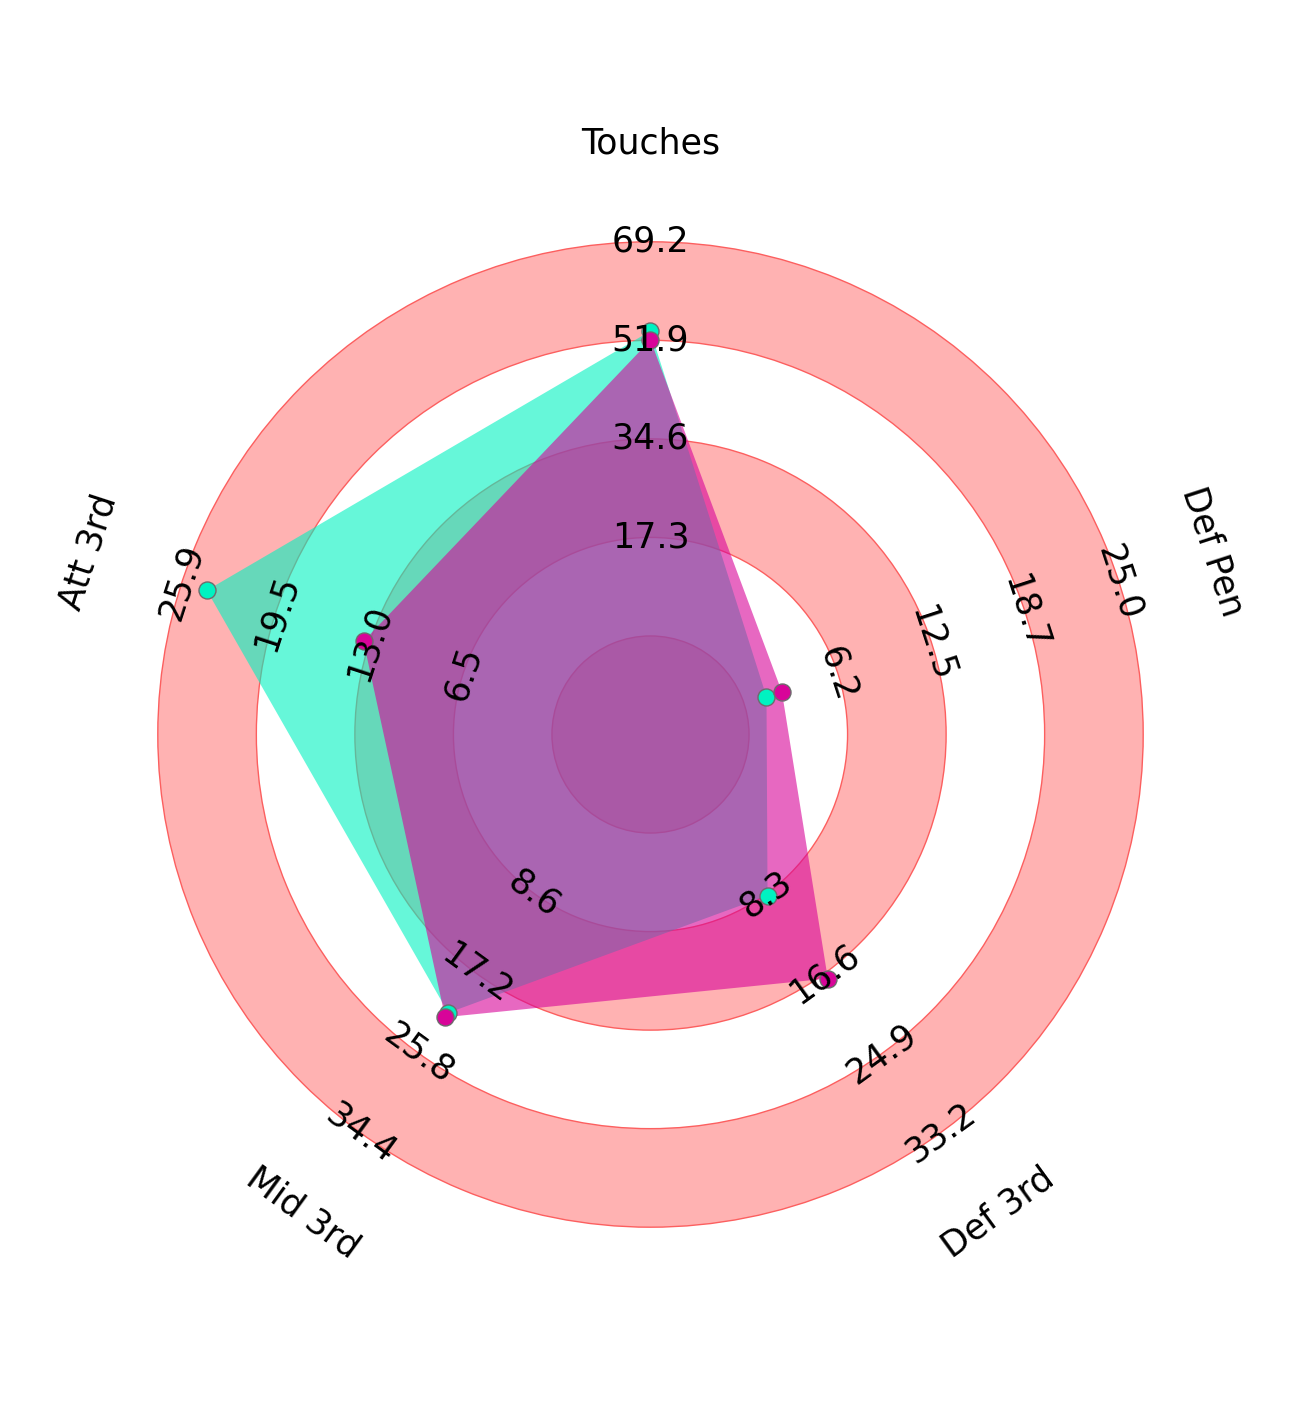

In [123]:
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

params = ['Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd']
low =[]
high =[]
for i in params:
    low.append(df[i].min())
    high.append(df[i].max())

radar = Radar(params, low, high,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)
bruno_values =  df.iloc[1][params].values
eriksen_values = df.iloc[9][params].values

# creating the figure using the grid function from mplsoccer:
fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot radar
radar.setup_axis(ax=axs['radar'])  # format axis as a radar
rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')
radar_output = radar.draw_radar_compare(bruno_values, eriksen_values, ax=axs['radar'],
                                        kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6},
                                        kwargs_compare={'facecolor': '#d80499', 'alpha': 0.6})
radar_poly, radar_poly2, vertices1, vertices2 = radar_output
range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=25)
axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                     c='#00f2c1', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
                     c='#d80499', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)
plt.show()